# Setup

Díky využití služeb  Google Colaboratory jsou veškeré příklady uvedené v této kapitole implementovány za využité jediného souboru Jupyter notebooku, který je konfigurován tak, aby jej po drobných úpravách (zejména lokalizaci příslušných dat uvnitř vlastního Google disku a autorizaci přístupu k tomuto Google disku uvnitř skriptu) mohl v prohlížeči spustit každý, kdo k němu prostřednictvím odkazu  získá přístup. a pomocí něj získat přístup k příslušné složce na Google disku, lokalizovat ji uvnitř vlastního diskového prostoru (volba “Add to my Drive”) a v podsložkách k jednotlivým případovým studiím zaměřit pozornost na soubory s koncovkou “ipynb”. Přistupujete-li ke google disku prostřednictvím webového prohlížeče, tyto soubory snadno spustíte přímo na platformě Colaboratory pomocí nabídky po pravém kliknutí myši (Open with -> Colaboratory). K plné funkčnosti doporučuji vytvořit si v rámci Google disku vlastní kopii celého adresáře.

In [0]:
### these should go easy
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', 150)

import numpy as np
import os
import string
import collections
import math
import random
import statistics as stat
import re
import unicodedata
import json

# Natural Language Processing Toolkit - we use it especially for building bigrams
import nltk
from nltk.collocations import *

### Beautiful Soup and Urllib
### for scrapping of web data and parsing xml files
from urllib.request import urlopen
# urllib and requests do basically the same, but my preferences are changing all the time, so let's import both
from urllib.parse import quote  
import requests
from bs4 import BeautifulSoup
### in some cases I prefer Element Tree
import xml.etree.cElementTree as ET


### for visualization
# in some cases I use matplotlib, which is much easier to configure, elsewhere I prefer Plotly, which is more "sexy"
import matplotlib.pyplot as plt
from PIL import Image

import seaborn as sns

### to generate wordcloud data
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator, get_single_color_func

# There is a lot of changes in Plotly nowadays. Perhaps some modifications of the code will be needed at some point
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.offline.init_notebook_mode(connected=True)

### for network analysis
import networkx as nx

### to export data to Google Spreadsheet
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

### google drive
from google.colab import drive

In [0]:
# authorize and mount google drive
drive.mount('/content/gdrive')
gdrive_root = "/content/gdrive/My Drive/a_PROJECTS/DiRECT-rep/aaa_distancni-cteni/" ### to be modified according to the user's gdrive structure

### to set gdrive_root as a folder to look at our own functions and modules
sys.path.append(gdrive_root)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
### authorize google sheets
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
# establish connection with particular sheet by its url:
sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/1LtHGTRt3uygNLBq386wKV6G7-HitkWaUTh5V6UTGnVM/edit?usp=sharing")

# Getting Czech NT Data 

In [0]:
### open the New Testament in Czech Ecumenical Translation from GitHUB

url = "https://raw.githubusercontent.com/getbible/Bibles/master/Czech__Czech_CEP__cep__LTR.txt"
textfile = urlopen(url).read().decode("utf-8")
textfile[:100]


'01O||1||1||Na počátku stvořil Bůh nebe a zemi.\r\n01O||1||2||Země byla pustá a prázdná a nad propastno'

In [0]:
### create verse-by-verse dataframe
bible = pd.read_csv(url, sep=r"\|+", names=["book", "c", "v", "text"])
bible.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



,book,c,v,text
0,01O,1,1,Na počátku stvořil Bůh nebe a zemi.
1,01O,1,2,Země byla pustá a prázdná a nad propastnou tůn...
2,01O,1,3,"I řekl Bůh: ""Buď světlo!"" A bylo světlo."
3,01O,1,4,"Viděl, že světlo je dobré, a oddělil světlo od..."
4,01O,1,5,Světlo nazval Bůh dnem a tmu nazval nocí. Byl ...


In [0]:
nt = bible[bible["book"].str.endswith("N")]
nt.reset_index(drop=True, inplace=True)
nt.head(5)

,book,c,v,text
0,40N,1,1,"Listina rodu Ježíše Krista, syna Davidova, syn..."
1,40N,1,2,"Abraham měl syna Izáka, Izák Jákoba, Jákob Jud..."
2,40N,1,3,"Juda Farese a Záru z Támary, Fares měl syna Ch..."
3,40N,1,4,"Aram měl syna Amínadaba, Amínadab Naasona, Naa..."
4,40N,1,5,"Salmón měl syna Boaze z Rachaby, Boaz Obéda z ..."


In [0]:
nt_books_keys = nt["book"].unique()
nt_books_keys

array(['40N', '41N', '42N', '43N', '44N', '45N', '46N', '47N', '48N',
       '49N', '50N', '51N', '52N', '53N', '54N', '55N', '56N', '57N',
       '58N', '59N', '60N', '61N', '62N', '63N', '64N', '65N', '66N'],
      dtype=object)

In [0]:
abbr_conv_df = get_as_dataframe(gc.open_by_key("1byVbRwnQ058--0ud1_NBt2xgIhuiV7LK1BmCm67CTxA").worksheet("AbbrevConverter"))
nt_books_values = abbr_conv_df["Czech"].tolist()[52:79]
nt_books_values = [abbr.replace(" ", "") for abbr in nt_books_values]
print(nt_books_values)

['Mt', 'Mk', 'L', 'J', 'Sk', 'Ř', '1K', '2K', 'Ga', 'Ef', 'Fp', 'Ko', '1Te', '2Te', '1Tm', '2Tm', 'Tt', 'Fm', 'Žd', 'Jk', '1P', '2P', '1J', '2J', '3J', 'Ju', 'Zj']


In [0]:
nt_books_dict = dict(zip(nt_books_keys, nt_books_values))
nt_books_dict["40N"]

'Mt'

In [0]:
nt["book_abbr"] = nt.apply(lambda row: nt_books_dict[row["book"]], axis=1)
### there is a warning message, but the command works

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [0]:
nt = nt[["book_abbr", "c", "v", "text"]]
nt.head(5)

,book_abbr,c,v,text
0,Mt,1,1,"Listina rodu Ježíše Krista, syna Davidova, syn..."
1,Mt,1,2,"Abraham měl syna Izáka, Izák Jákoba, Jákob Jud..."
2,Mt,1,3,"Juda Farese a Záru z Támary, Fares měl syna Ch..."
3,Mt,1,4,"Aram měl syna Amínadaba, Amínadab Naasona, Naa..."
4,Mt,1,5,"Salmón měl syna Boaze z Rachaby, Boaz Obéda z ..."


In [0]:
nt[nt["book_abbr"]=="J"]["text"].values[:10]

array(['Na počátku bylo Slovo, to Slovo bylo u Boha, to Slovo byl Bůh.',
       'To bylo na počátku u Boha.',
       'Všechno povstalo skrze ně a bez něho nepovstalo nic, co jest.',
       'V něm byl život a život byl světlo lidí.',
       'To světlo ve tmě svítí a tma je nepohltila.',
       'Od Boha byl poslán člověk, jménem Jan.',
       'Ten přišel proto, aby vydal svědectví o tom světle, aby všichni uvěřili skrze něho.',
       'Jan sám nebyl tím světlem, ale přišel, aby o tom světle vydal svědectví.',
       'Bylo tu pravé světlo, které osvěcuje každého člověka; to přicházelo do světa.',
       'Na světě byl, svět skrze něj povstal, ale svět ho nepoznal.'],
      dtype=object)

# Functions for Data Cleaning and Preprocessing

In [0]:
def czech_sentences_maker(string):
  """splits text into sentences (not needed for the NT)"""
  text_splitted = re.split('([a-z|\"|ů|í|á|\d\d\d\d])(\.|\?|\!\s)', string)  
  sentences = []
  n = 0
  for element in text_splitted:
    n = n + 1
    if n == 1:
      sentence_main = element
    if n == 2:
      sentence_ending = element
    if n == 3:
      sentence_separator = element
      sentences.append(sentence_main + sentence_ending + sentence_separator)
      n = 0
  return sentences

def lemmata_filtered(string):
  try:
    url = 'http://lindat.mff.cuni.cz/services/morphodita/api/tag?data=' + quote(string)
    resp = urlopen(url)
    file = resp.read().decode("utf-8")
    result = dict(json.loads(file))["result"]
    soup = BeautifulSoup(result, 'html.parser')
    lemmata = []
    for token in soup.find_all("token"):
      if token["tag"].startswith(("V","N","A", "C")):
        lemma = token["lemma"].partition("-")[0].partition("_")[0]
        if "`" in lemma:
          lemma = lemma.partition("`")[2]
        if len(lemma) > 1:
          lemmata.append(lemma)
  except:
    lemmata = [""]
  return lemmata

# Short one sentence long testing

In [0]:
test_string = "Hlas volajícího na poušti: Připravte cestu Páně, vyrovnejte mu stezky!"
test_data = []
url = 'http://lindat.mff.cuni.cz/services/morphodita/api/tag?data=' + quote(test_string)
resp = urlopen(url)
file = resp.read().decode("utf-8")
result = dict(json.loads(file))["result"]
soup = BeautifulSoup(result, 'html.parser')
for token in soup.find_all("token"):
  lemma = token["lemma"].partition("-")[0].partition("_")[0]
  test_data.append([token.get_text(), token["tag"], lemma])
test_data

[['Hlas', 'NNIS1-----A----', 'hlas'],
 ['volajícího', 'AGIS2-----A----', 'volající'],
 ['na', 'RR--6----------', 'na'],
 ['poušti', 'NNFS6-----A----', 'poušť'],
 [':', 'Z:-------------', ':'],
 ['Připravte', 'Vi-P---2--A----', 'připravit'],
 ['cestu', 'NNFS4-----A----', 'cesta'],
 ['Páně', 'NNMS2-----A---2', 'Pán'],
 [',', 'Z:-------------', ','],
 ['vyrovnejte', 'Vi-P---2--A----', 'vyrovnat'],
 ['mu', 'PHZS3--3-------', 'on'],
 ['stezky', 'NNFP4-----A----', 'stezka'],
 ['!', 'Z:-------------', '!']]

In [0]:
nt.values.tolist()[:3]

[['Mt', 1, 1, 'Listina rodu Ježíše Krista, syna Davidova, syna Abrahamova.'],
 ['Mt',
  1,
  2,
  'Abraham měl syna Izáka, Izák Jákoba, Jákob Judu a jeho bratry,'],
 ['Mt',
  1,
  3,
  'Juda Farese a Záru z Támary, Fares měl syna Chesróma, Chesróm Arama.']]

In [0]:
set_with_dataframe(sh.add_worksheet(title="test_sentence", rows=1, cols=1), pd.DataFrame(test_data))

In [0]:
nt["book_abbr"].unique().tolist()

['Mt',
 'Mk',
 'L',
 'J',
 'Sk',
 'Ř',
 '1K',
 '2K',
 'Ga',
 'Ef',
 'Fp',
 'Ko',
 '1Te',
 '2Te',
 '1Tm',
 '2Tm',
 'Tt',
 'Fm',
 'Žd',
 'Jk',
 '1P',
 '2P',
 '1J',
 '2J',
 '3J',
 'Ju',
 'Zj']

In [0]:
### MAIN FUNCTION APPLICATION
### the text is lemmatized verse by verse and a dictionary of NT books is formed
### the dictionary element for each book is a dictionary containing:
### (1) "book_length_orig" = number of words in the source text
### (2) "book_length_filtered" = number of lemmatized words in the filtered text
### (3) "book_lemmata" = filtered lemmata as a list of words
### (4) "book_by_verse" = a list of list with cells for (a) book chapter, (b) verse number, (c) original text of the verse, (d) filtered lemmata for the verse


nt_data = {}
for book_abbr in nt["book_abbr"].unique().tolist():
  actual_book = nt[nt["book_abbr"]==book_abbr]
  book_lemmata = [] 
  book_length_orig = 0
  book_by_verse = []
  for verse_row in actual_book.values.tolist():
    verse_lemmata = lemmata_filtered(verse_row[3])
    book_lemmata.extend(verse_lemmata)
    book_length_orig = book_length_orig + len(str(verse_row[3]).split())
    book_by_verse.append([verse_row[1], verse_row[2], verse_row[3], verse_lemmata])
  book_length_filtered = len(book_lemmata)
  nt_data.update({book_abbr : {"book_length_orig" : book_length_orig, "book_length_filtered" : book_length_filtered, "book_lemmata" : book_lemmata, "book_by_verse" : book_by_verse}})

In [0]:
print(nt_data["Mk"]["book_lemmata"][:100])

['počátek', 'evangelium', 'Ježíš', 'Kristus', 'syn', 'boží', 'být', 'psát', 'prorok', 'Izaiáš', 'posílat', 'posel', 'tvář', 'být', 'připravit', 'cesta', 'hlas', 'volající', 'poušť', 'připravit', 'cesta', 'Pán', 'vyrovnat', 'stezka', 'stát', 'Jan', 'křtitel', 'vystoupit', 'poušť', 'kázat', 'činit', 'pokání', 'dát', 'pokřtít', 'odpuštění', 'hřích', 'celý', 'judský', 'krajina', 'Jeruzalém', 'vycházet', 'vyznávat', 'hřích', 'dávat', 'křtít', 'řeka', 'Jordán', 'Jan', 'být', 'odít', 'velbloudí', 'srst', 'mít', 'kožený', 'pás', 'bok', 'jíst', 'kobylka', 'med', 'divoký', 'včela', 'kázat', 'přicházet', 'silný', 'být', 'být', 'hodný', 'sklonit', 'rozvázat', 'řemínek', 'obuv', 'být', 'křtít', 'voda', 'být', 'křtít', 'duch', 'svatý', 'den', 'přijít', 'Ježíš', 'Nazaret', 'Galilea', 'být', 'Jordán', 'Jan', 'pokřtít', 'vystupovat', 'voda', 'uvidět', 'nebesa', 'rozevřený', 'duch', 'holubice', 'sestupovat', 'nebe', 'ozvat', 'hlas', 'být', 'milovaný']


In [0]:
with open(gdrive_root + 'data/nt_data_json.json', 'w') as json_file:
  json.dump(nt_data, json_file)

# To start with preprocessed data

In [0]:
### upload the data in the json/dict format
with open(gdrive_root + 'data/nt_data_json.json', 'r') as json_file:
  nt_data = json.loads(json_file.read())

In [0]:
print(nt_data["Mk"]["book_by_verse"])

[[1, 1, 'Počátek evangelia Ježíše Krista, Syna Božího.', ['počátek', 'evangelium', 'Ježíš', 'Kristus', 'syn', 'boží']], [1, 2, "Je psáno u proroka Izaiáše: 'Hle, já posílám posla před tvou tváří, by ti připravil cestu.", ['být', 'psát', 'prorok', 'Izaiáš', 'posílat', 'posel', 'tvář', 'být', 'připravit', 'cesta']], [1, 3, "Hlas volajícího na poušti: Připravte cestu Páně, vyrovnejte mu stezky!'", ['hlas', 'volající', 'poušť', 'připravit', 'cesta', 'Pán', 'vyrovnat', 'stezka']], [1, 4, 'To se stalo, když Jan Křtitel vystoupil na poušti a kázal: "Čiňte pokání a dejte se pokřtít na odpuštění hříchů."', ['stát', 'Jan', 'křtitel', 'vystoupit', 'poušť', 'kázat', 'činit', 'pokání', 'dát', 'pokřtít', 'odpuštění', 'hřích']], [1, 5, 'Celá judská krajina i všichni z Jeruzaléma vycházeli k němu, vyznávali své hříchy a dávali se od něho křtít v řece Jordánu.', ['celý', 'judský', 'krajina', 'Jeruzalém', 'vycházet', 'vyznávat', 'hřích', 'dávat', 'křtít', 'řeka', 'Jordán']], [1, 6, 'Jan byl oděn velblou

In [0]:
### for some overview it might be easier to use a dataframe format
nt_data_df = pd.DataFrame.from_dict(nt_data, orient="index")
nt_data_df.head(3)

,book_length_orig,book_length_filtered,book_lemmata_string,book_by_verse,book_lemmata
1J,1936,998,být počátek být slyšet být vlastní oko vidět b...,"[[1, 1, Co bylo od počátku, co jsme slyšeli, c...","[být, počátek, být, slyšet, být, vlastní, oko,..."
1K,7215,3793,Pavel vůle boží povolaný apoštol Kristus Ježíš...,"[[1, 1, Pavel, z vůle Boží povolaný apoštol Kr...","[Pavel, vůle, boží, povolaný, apoštol, Kristus..."
1P,1903,1018,Petr apoštol Ježíš Kristus vyvolený přebývat c...,"[[1, 1, Petr, apoštol Ježíše Krista, vyvoleným...","[Petr, apoštol, Ježíš, Kristus, vyvolený, přeb..."


In [0]:
nt_data_df["book_length_orig"].sum()

134188

In [0]:
nt_data_df["book_length_filtered"].sum()

70709

# Bag-of-words

In [0]:
evangelia = ["Mt", "Mk", "L", "J"]
for evangelium in evangelia:
  lemmata = nt_data[evangelium]["book_lemmata"]
  lemmata_without_byt = [word for word in lemmata if word != "být"]
  print(lemmata_without_byt)

['listina', 'rod', 'Ježíš', 'Kristus', 'syn', 'Davidov', 'syn', 'Abrahamův', 'Abraham', 'mít', 'syn', 'Izák', 'Izák', 'Jákob', 'Jákob', 'Juda', 'bratr', 'Juda', 'farese', 'záru', 'Támar', 'Fares', 'mít', 'syn', 'Chesróma', 'chesróm', 'Aram', 'Aram', 'mít', 'syn', 'Amínadab', 'Amínadab', 'naasona', 'Naason', 'salmóna', 'Salmón', 'mít', 'syn', 'Boaz', 'Rachaby', 'Boaz', 'Obéda', 'Rút', 'Obédský', 'isaje', 'Isaj', 'David', 'král', 'David', 'mít', 'syn', 'Šalomoun', 'žena', 'Uriášův', 'Šalomoun', 'Roboáma', 'roboám', 'abiu', 'Abia', 'Asafa', 'Asaf', 'Jóšafata', 'Jóšafat', 'Jór', 'Jóram', 'uziáše', 'Uziáš', 'mít', 'syn', 'jótama', 'Jótam', 'Achaza', 'Achaz', 'Ezechiáš', 'Ezechiáš', 'Manas', 'Manas', 'mít', 'syn', 'Amos', 'Amos', 'joziáše', 'Joziáš', 'jechoniáše', 'bratr', 'babylónský', 'zajetí', 'babylónský', 'zajetí', 'Jechoniáš', 'mít', 'syn', 'Salatiet', 'Salatiel', 'Zorobabela', 'Zorobabel', 'Abiuda', 'Abiudební', 'Eljakima', 'Eljakim', 'Azóra', 'Azór', 'Sádok', 'Sádok', 'Achim', 'Achim

In [0]:
def get_most_frequent(book_abbr, number):
  lemmata = nt_data[book_abbr]["book_lemmata"]
  lemmata_without_byt = [word for word in lemmata if word != "být"]
  most_common_tuples = nltk.FreqDist(lemmata_without_byt).most_common(number)
  most_common_tuples_rel = [(pair[0], np.round(pair[1] / nt_data[book_abbr]["book_length_orig"], 7)) for pair in most_common_tuples]
  most_common_words = [pair[0] for pair in most_common_tuples]
  most_common_numbers = [pair[1] for pair in most_common_tuples]
  most_common_string = [pair[0] + " (" + str(round(pair[1], 5)) + ")" for pair in most_common_tuples_rel]
  most_common_dict = {}
  for pair in most_common_tuples:
    most_common_dict.update({pair[0] : int(pair[1])})
  return [most_common_string, most_common_words, most_common_numbers, most_common_dict, most_common_tuples, most_common_tuples_rel]

In [0]:
for book_abbr in evangelia:
  print(get_most_frequent(book_abbr, 10)[5])

[('říci', 0.0136775), ('Ježíš', 0.0093958), ('mít', 0.0068982), ('jít', 0.0063035), ('člověk', 0.0063035), ('syn', 0.0059467), ('přijít', 0.0059467), ('dát', 0.00446), ('učedník', 0.0042816), ('odpovědět', 0.0042222)]
[('říci', 0.0151846), ('Ježíš', 0.0099649), ('mít', 0.0080668), ('přijít', 0.0066433), ('jít', 0.0064534), ('člověk', 0.0063585), ('učedník', 0.0045554), ('duch', 0.0035114), ('moci', 0.0035114), ('říkat', 0.0035114)]
[('říci', 0.0156309), ('mít', 0.0081411), ('Ježíš', 0.0068928), ('člověk', 0.0064043), ('přijít', 0.0056445), ('dát', 0.0047218), ('jít', 0.0043962), ('den', 0.0042877), ('syn', 0.0042334), ('bůh', 0.0037449)]
[('říci', 0.0193462), ('Ježíš', 0.0168043), ('otec', 0.0091082), ('mít', 0.0084022), ('přijít', 0.0067782), ('odpovědět', 0.0062134), ('učedník', 0.0056485), ('svět', 0.0055073), ('jít', 0.0052955), ('dát', 0.0050131)]


In [0]:
most_frequent_all = []
for book_abbr in evangelia:
  most_frequent_all.append(get_most_frequent(book_abbr, 10)[0])
  
most_common_df = pd.DataFrame(most_frequent_all).transpose()
most_common_df.columns = evangelia
most_common_df

,Mt,Mk,L,J
0,říci (0.01368),říci (0.01518),říci (0.01563),říci (0.01935)
1,Ježíš (0.0094),Ježíš (0.00996),mít (0.00814),Ježíš (0.0168)
2,mít (0.0069),mít (0.00807),Ježíš (0.00689),otec (0.00911)
3,jít (0.0063),přijít (0.00664),člověk (0.0064),mít (0.0084)
4,člověk (0.0063),jít (0.00645),přijít (0.00564),přijít (0.00678)
5,syn (0.00595),člověk (0.00636),dát (0.00472),odpovědět (0.00621)
6,přijít (0.00595),učedník (0.00456),jít (0.0044),učedník (0.00565)
7,dát (0.00446),duch (0.00351),den (0.00429),svět (0.00551)
8,učedník (0.00428),moci (0.00351),syn (0.00423),jít (0.0053)
9,odpovědět (0.00422),říkat (0.00351),bůh (0.00374),dát (0.00501)


In [0]:
### delete the previous version
sh.del_worksheet(sh.worksheet(title="most_common"))
### create new sheet
set_with_dataframe(sh.add_worksheet(title="most_common", rows=1, cols=1), pd.DataFrame(most_common_df))

# Combine with SYN data and TF-IDF

In [0]:
### for details, see http://ucnk.korpus.cz/srovnani10.php
### (it seems that it does not work from abroad - is it possible?)

syn2010_lemma = pd.read_csv("http://ucnk.korpus.cz/doc/seznamy10/syn2010_lemma.zip", sep="\t", encoding="cp1250", names=["rank", "lemma", "freq_abs", "freq_recount", "beletrie", "odborna", "publicistika"])
syn2010_lemma.set_index("lemma", inplace=True)

In [0]:
syn_len = syn2010_lemma["freq_abs"].sum() 
syn_len

In [0]:
syn2010_lemma["syn_rel"] = syn2010_lemma.apply(lambda row: row["freq_abs"]/ syn_len, axis=1)
syn2010_lemma.head(5)

In [0]:
def tf_idf_calculator(term, book_abbr, whole_dataset):
  tf = nt_data[book_abbr]["book_lemmata"].count(term) / nt_data[book_abbr]["book_length_orig"]
  number_of_matched = 0
  for book_abbr_local in whole_dataset:
    if term in nt_data[book_abbr_local]["book_lemmata"]:
      number_of_matched = number_of_matched + 1
  idf = math.log(len(whole_dataset) / number_of_matched)
  tf_idf = tf * idf
  return (term, round(tf_idf, 5))

In [0]:
for book_abbr in evangelia:
  tfidf_pairs = []
  for term in list(set(nt_data[book_abbr]["book_lemmata"])):
    tf_idf_pair = tf_idf_calculator(term, book_abbr, nt_data.keys())
    tfidf_pairs.append(tf_idf_pair)
  tfidf_pairs_sorted = sorted(tfidf_pairs, key=lambda tup: np.round(tup[1], 5), reverse=True)
  print(tfidf_pairs_sorted[:10])

[('učedník', 0.00722), ('odpovědět', 0.00464), ('říci', 0.00344), ('pravit', 0.00309), ('zástup', 0.00284), ('pan', 0.00265), ('farizeus', 0.00259), ('jít', 0.00256), ('Jan', 0.00217), ('přistoupit', 0.00217)]
[('učedník', 0.00768), ('říci', 0.00382), ('odpovědět', 0.00334), ('zástup', 0.0032), ('Jan', 0.00307), ('zákoník', 0.003), ('chléb', 0.00282), ('mistr', 0.00272), ('jít', 0.00262), ('velekněz', 0.00257)]
[('říci', 0.00393), ('učedník', 0.00366), ('odpovědět', 0.00346), ('Jan', 0.00227), ('zástup', 0.00226), ('mistr', 0.00218), ('farizeus', 0.00212), ('pan', 0.00205), ('pravit', 0.00202), ('vejít', 0.00191)]
[('učedník', 0.00953), ('odpovědět', 0.00683), ('říci', 0.00486), ('pan', 0.00305), ('Šimon', 0.00255), ('Petr', 0.00248), ('oslavit', 0.00243), ('Lazar', 0.00239), ('svátek', 0.00238), ('žid', 0.00222)]


In [0]:
### IDF separately
ucednik = 0
for book_abbr in nt_data.keys():
  if "učedník" in nt_data[book_abbr]["book_lemmata"]:
    ucednik = ucednik + 1
ucednik

5

In [0]:
IDF = math.log(27 / ucednik)
round(IDF, 5)

1.6864

In [0]:
### TF separately
TF = nt_data["J"]["book_lemmata"].count("učedník") / nt_data["J"]["book_length_orig"]
TF

0.005648520793617172

In [0]:
TF * IDF

0.009525659555575676

In [0]:
def get_CNKfreq_and_TFIDF(book_abbr, number_of_words, document_set):
  actual_list = get_most_frequent(book_abbr, number_of_words)[5]
  new_pairs_for_sorting = []
  for pair in actual_list:
    try: 
      frequency_in_syn = syn2010_lemma.at[pair[0], "syn_rel"]
      frequency_compared = pair[1] / frequency_in_syn
      tf_idf = tf_idf_calculator(pair[0], book_abbr, document_set)[1]
      new_pairs_for_sorting.append((pair[0], round(pair[1], 5), round(frequency_in_syn, 5), round(frequency_compared, 5), round(tf_idf, 5)))
    except:
      pass
  pairs_sorted = sorted(new_pairs_for_sorting, key=lambda tup: tup[4], reverse=True)
  pairs_quad = int(len(pairs_sorted) / 4)
  pairs_25spec = [element[0] for element in pairs_sorted[:pairs_quad]]
  pairs_50avr = [element[0] for element in pairs_sorted[pairs_quad:-pairs_quad]]
  pairs_25common = [element[0] for element in pairs_sorted[-pairs_quad:]]
  return [pairs_25spec, pairs_50avr, pairs_25common, pairs_sorted]                       

In [0]:
for book_abbr in evangelia:
  print(get_CNKfreq_and_TFIDF(book_abbr, 100, nt_data.keys())[3])

In [0]:
various_metrics_jan = pd.DataFrame(get_CNKfreq_and_TFIDF("J", 10, nt_data.keys())[3])
various_metrics_jan.columns = ["term", "TF", "TFSYN", "TF/TFSYN","TF-IDF"]
various_metrics_jan.round(5)

,term,TF,TFSYN,TF/TFSYN,TF-IDF
0,učedník,0.00565,0.00001,1002.49284,0.00953
1,odpovědět,0.00621,0.00025,24.90400,0.00683
2,říci,0.01935,0.00214,9.03170,0.00486
3,jít,0.00530,0.00158,3.34660,0.00215
4,svět,0.00551,0.00082,6.70035,0.00138
5,Ježíš,0.01680,0.00003,489.45405,0.00063
6,dát,0.00501,0.00116,4.33021,0.00039
7,otec,0.00911,0.00035,26.10539,0.00034
8,přijít,0.00678,0.00081,8.42003,0.00026
9,mít,0.00840,0.00741,1.13402,0.00000


In [0]:
### delete the previous version
sh.del_worksheet(sh.worksheet(title="various_metrics_jan"))
### create new sheet
set_with_dataframe(sh.add_worksheet(title="various_metrics_jan", rows=1, cols=1), various_metrics_jan.round(5))

In [0]:
def wordcloud_object_generator_from_dict(frequencies, color_to_words_actual, file_name, save_or_show, max_number_of_words, biggest_text, wc_width, wc_height, plt_width, plt_height, dpi):
  wordcloud = WordCloud(max_font_size=60, width=200, height=500, max_words=100, background_color="white", margin=0).generate_from_frequencies(frequencies)
  default_color = "gray"
  grouped_color_func = SimpleGroupedColorFunc(color_to_words_actual, default_color)
  wordcloud.recolor(color_func=grouped_color_func)
  plt.rcParams['figure.dpi'] = 100
  plt.rcParams['figure.figsize'] = [2, 5]
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.margins(0,0)
  if save_or_show == "save": plt.savefig(gdrive_root + "figures/NT_wordclouds/" + file_name + ".png", format="png", bbox_inches="tight")
  if save_or_show == "show": plt.show()

### copied from: https://amueller.github.io/word_cloud/auto_examples/colored_by_group.html#
class SimpleGroupedColorFunc(object):
    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

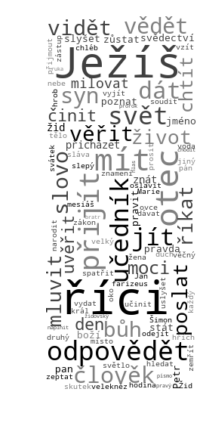

In [0]:
most_frequent_all = []
for evangelium in evangelia:
  frequencies = get_most_frequent(evangelium, 100)[3]
  lists_for_colors = get_CNKfreq_and_TFIDF(evangelium, 100, nt_data.keys())
  color_to_words_actual = {
      "#000000" : lists_for_colors[0], # 25% of most specific words in comparison to CNK
      "#404040" : lists_for_colors[1], # 50% of words in the middle
      "#808080" : lists_for_colors[2]} # 25% of words with lowest values
  wordcloud_object_generator_from_dict(frequencies, color_to_words_actual, evangelium, "save", 100, 40, 300, 300, 3, 3, 100)

# Greek translator

In [0]:
### we want the terms with translation
### Dodson's dictionary parsed using Beautiful Soup
url = "https://raw.githubusercontent.com/biblicalhumanities/Dodson-Greek-Lexicon/master/dodson.xml"
primary_dict = {}
page = urlopen(url)
soup = BeautifulSoup(page, 'xml')
for element in soup.find_all("entry"):
    primary_dict.update({element.orth.get_text().partition(",")[0].lower() : element.find("def").get_text()})


### morphesus dictionary parsed using ETREE
urls = ["https://raw.githubusercontent.com/gcelano/MorpheusGreekUnicode/master/MorpheusGreek1-319492.xml", "https://raw.githubusercontent.com/gcelano/MorpheusGreekUnicode/master/MorpheusGreek319493-638984.xml", "https://raw.githubusercontent.com/gcelano/MorpheusGreekUnicode/master/MorpheusGreek638985-958476.xml"]
morpheus_dict = {}
for url in urls:
    page = urlopen(url)
    tree = ET.parse(page)
    root = tree.getroot()
    for element in root.iter("t"):
        morpheus_dict.update({element.find("l").text.lower() : element.find("s").text})

def translator_short(term):
    """Replace "GREEKWORD" by "GREEKWORD (english translation)"""
    term = unicodedata.normalize("NFC", term)
    try:
        if term in primary_dict:
            translation = primary_dict.get(term)
            translation = (", ").join(translation.split(", ")[:2])
            term_with_translation = term+ " (" + translation +")"
        else: 
            if term in morpheus_dict:
                term_with_translation = term+ " (" + morpheus_dict.get(term) +")"
            else:
                term_with_translation = term
        return term_with_translation
    except:
        pass


def list_of_meanings(term):
    """return meanings"""
    term = unicodedata.normalize("NFC", term)
    try:
        if term in primary_dict:
            translation = primary_dict.get(term).split(", ")
        else: 
            if term in morpheus_dict:
                translation = morpheus_dict.get(term).split(", ")
            else:
                translation = [] 
        return translation
    except:
        pass

# Network Functions

In [0]:
def network_formation_df(dataset, column, book_abbr, lexicon_size, threshold):
    '''From a dataframe with rows corresponding to individual documents,
    to be subsellected on the basis of author's name column, for instance'''
    lemmata_list = dataset[book_abbr][column]
    lemmata_list = [lemma for lemma in lemmata_list if lemma != "být"]
    lemmata_list = [lemma for lemma in lemmata_list if lemma != "εἰμί"]
    lexicon = [word_tuple[0] for word_tuple in nltk.FreqDist(lemmata_list).most_common(lexicon_size)]
    bigrams_list = []
    for bigram in nltk.bigrams([lemma for lemma in lemmata_list if lemma != "být"]):
      if ((bigram[0] in lexicon) & (bigram[1] in lexicon)):
        if bigram[0] != bigram[1]:
          bigrams_list.append(tuple(sorted(bigram)))
    bigrams_counts = list((collections.Counter(bigrams_list)).items())
    bigrams_counts = sorted(bigrams_counts, key=lambda x: x[1], reverse=True)
    ### create a NetworkX object
    G = nx.Graph()
    G.clear()
    ### form the network from tuples of this form: (node1, node2, number of co-occurrences / lenght of the document)
    G.add_weighted_edges_from(np.array([(bigram_count[0][0], bigram_count[0][1],  int(bigram_count[1])) for bigram_count in bigrams_counts if bigram_count[1] >= threshold]))
    ### add edges attributes 
    for (u, v, wt) in G.edges.data('weight'):
        G[u][v]["weight"] = int(wt)
    total_weight = sum([int(n) for n in nx.get_edge_attributes(G, "weight").values()])
    for (u, v) in G.edges:
        G[u][v]["norm_weight"] = round((G[u][v]["weight"] / total_weight), 5)
        G[u][v]["distance"] = round(1 / (G[u][v]["weight"]), 5)
        G[u][v]["norm_distance"] = round(1 / (G[u][v]["norm_weight"] ), 5)
    return G

def network_from_lemmata_list(lemmata_list, lexicon_size, threshold):
    '''From a list of words'''
    lemmata_list = [lemma for lemma in lemmata_list if lemma != "být"]
    lemmata_list = [lemma for lemma in lemmata_list if lemma != "εἰμί"]
    lexicon = [word_tuple[0] for word_tuple in nltk.FreqDist(lemmata_list).most_common(lexicon_size)]
    bigrams_list = []
    for bigram in nltk.bigrams([lemma for lemma in lemmata_list if lemma != "být"]):
      if ((bigram[0] in lexicon) & (bigram[1] in lexicon)):
        if bigram[0] != bigram[1]:
          bigrams_list.append(tuple(sorted(bigram)))
    bigrams_counts = list((collections.Counter(bigrams_list)).items())
    bigrams_counts = sorted(bigrams_counts, key=lambda x: x[1], reverse=True)
    ### create a NetworkX object
    G = nx.Graph()
    G.clear()
    ### form the network from tuples of this form: (node1, node2, number of co-occurrences / lenght of the document)
    G.add_weighted_edges_from(np.array([(bigram_count[0][0], bigram_count[0][1],  int(bigram_count[1])) for bigram_count in bigrams_counts if bigram_count[1] >= threshold]))
    ### add edges attributes 
    for (u, v, wt) in G.edges.data('weight'):
        G[u][v]["weight"] = int(wt)
    total_weight = sum([int(n) for n in nx.get_edge_attributes(G, "weight").values()])
    for (u, v) in G.edges:
        G[u][v]["norm_weight"] = round((G[u][v]["weight"] / total_weight), 5)
        G[u][v]["distance"] = round(1 / (G[u][v]["weight"]), 5)
        G[u][v]["norm_distance"] = round(1 / (G[u][v]["norm_weight"] ), 5)
    return G
  
def network_by_author(dataset, column, book_abbr, lexicon_size, threshold):
    '''From a dataframe with rows corresponding to individual documents,
    to be subsellected on the basis of author's name column, for instance'''
    works = dataset[dataset["author"]==book_abbr][column].tolist()
    works_merged = [item for sublist in works for item in sublist]
    lexicon = [word_tuple[0] for word_tuple in nltk.FreqDist(works_merged).most_common(lexicon_size)]
    bigrams_list = []
    for work in works:
      for bigram in nltk.bigrams([lemma for lemma in work if lemma != "εἰμί"]):
        if ((bigram[0] in lexicon) & (bigram[1] in lexicon)):
          if bigram[0] != bigram[1]:
            bigrams_list.append(tuple(sorted(bigram)))
    bigrams_counts = list((collections.Counter(bigrams_list)).items())
    bigrams_counts = sorted(bigrams_counts, key=lambda x: x[1], reverse=True)
    ### create a NetworkX object
    G = nx.Graph()
    G.clear()
    ### form the network from tuples of this form: (node1, node2, number of co-occurrences / lenght of the document)
    G.add_weighted_edges_from(np.array([(bigram_count[0][0], bigram_count[0][1],  int(bigram_count[1])) for bigram_count in bigrams_counts if bigram_count[1] >= threshold]))
    ### add distance attribute
    for (u, v, wt) in G.edges.data('weight'):
        G[u][v]["weight"] = int(wt)
    total_weight = sum([int(n) for n in nx.get_edge_attributes(G, "weight").values()])
    for (u, v) in G.edges:
        G[u][v]["norm_weight"] = round((G[u][v]["weight"] / total_weight), 5)
        G[u][v]["distance"] = round(1 / (G[u][v]["weight"]), 5)
        G[u][v]["norm_distance"] = round(1 / (G[u][v]["norm_weight"] ), 5)
    return G

def draw_2d_network(networkx_object, file_name, mode):
    '''take networkX object and draw it'''
    pos_2d=nx.kamada_kawai_layout(networkx_object, weight="weight_norm")
    nx.set_node_attributes(networkx_object, pos_2d, "pos_2d")
    dmin=1
    ncenter=0
    Edges = list(networkx_object.edges)
    L=len(Edges)
    labels= list(networkx_object.nodes)
    N = len(labels)
    distance_list = [float(distance[2]) for distance in list(networkx_object.edges.data("distance"))]
    weight_list = [int(float(weight[2])) for weight in list(networkx_object.edges.data("weight"))]
    for n in pos_2d:
        x,y=pos_2d[n]
        d=(x-0.5)**2+(y-0.5)**2
        if d<dmin:
            ncenter=n
            dmin=d
    p =nx.single_source_shortest_path_length(networkx_object, ncenter)
    adjc= [len(one_adjc) for one_adjc in list((nx.generate_adjlist(networkx_object)))]
    middle_node_trace = go.Scatter(
        x=[],
        y=[],
        opacity=0,
        text=weight_list,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            opacity=0
            )
        )
    for Edge in Edges:
        x0,y0 = networkx_object.nodes[Edge[0]]["pos_2d"]
        x1,y1 = networkx_object.nodes[Edge[1]]["pos_2d"]
        middle_node_trace['x'] += tuple([(x0+x1)/2])
        middle_node_trace['y'] += tuple([(y0+y1)/2])
    edge_trace1 = go.Scatter(
        x=[], y=[],
        #hoverinfo='none',
        mode='lines',
        line=dict(width=1,color="#000000"),
        )
    edge_trace2 = go.Scatter(
        x=[],y=[],
        #hoverinfo='none',
        mode='lines',
        line=dict(width=0.7,color="#404040"),
        )
    edge_trace3 = go.Scatter(
        x=[], y=[],
        #hoverinfo='none',
        mode='lines',
        line=dict(width=0.5,color="#C0C0C0"),
        )
    best_5percent_norm_weight = sorted(list(networkx_object.edges.data("norm_weight")), key=lambda x: x[2], reverse=True)[int((len(networkx_object.edges.data("norm_weight")) / 100) * 5)][2]
    best_20percent_norm_weight = sorted(list(networkx_object.edges.data("norm_weight")), key=lambda x: x[2], reverse=True)[int((len(networkx_object.edges.data("norm_weight")) / 100) * 20)][2]
    for edge in networkx_object.edges.data():
        if edge[2]["norm_weight"] >= best_5percent_norm_weight:
            x0, y0 = networkx_object.nodes[edge[0]]['pos_2d']
            x1, y1 = networkx_object.nodes[edge[1]]['pos_2d']
            edge_trace1['x'] += tuple([x0, x1, None])
            edge_trace1['y'] += tuple([y0, y1, None])
        else:
            if edge[2]["norm_weight"] >= best_20percent_norm_weight:
                x0, y0 = networkx_object.nodes[edge[0]]['pos_2d']
                x1, y1 = networkx_object.nodes[edge[1]]['pos_2d']
                edge_trace2['x'] += tuple([x0, x1, None])
                edge_trace2['y'] += tuple([y0, y1, None])
            else:
                x0, y0 = networkx_object.nodes[edge[0]]['pos_2d']
                x1, y1 = networkx_object.nodes[edge[1]]['pos_2d']
                edge_trace3['x'] += tuple([x0, x1, None])
                edge_trace3['y'] += tuple([y0, y1, None])

    node_trace = go.Scatter(
        x=[],
        y=[],
        #name=[],
        text=[],
        textposition='bottom center',
        mode='markers+text',
        hovertext=adjc,
        hoverinfo='text',
        marker=dict(
            ###showscale=True,
            showscale=False, ### change to see scale
            colorscale='Greys',
            reversescale=True,
            color=[],
            size=7,
            colorbar=dict(
                thickness=15,
                title='degree',
                xanchor='left',
                titleside='right'
                ),
            line=dict(width=1)
            )
        )

    for node in networkx_object.nodes():
        x, y = networkx_object.nodes[node]['pos_2d']
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        node_trace["text"] += tuple([node])
        ### original version: node_trace["text"] += tuple([node])

    ### Color Node Points
    for node, adjacencies in enumerate(nx.generate_adjlist(networkx_object)):
        node_trace['marker']['color'] += tuple([len(adjacencies)])
        ###node_info = ' of connections: '+str(len(adjacencies))
        ###node_trace['something'].append(node_info)

    fig = go.Figure(data=[edge_trace1, edge_trace2, edge_trace3, node_trace, middle_node_trace],
        layout=go.Layout(
            plot_bgcolor='rgba(0,0,0,0)',
            autosize=False,
            width=500,
            height=500,
            #title=file_name,
            titlefont=dict(size=16),
            showlegend=False,
            hovermode='closest',
            margin=dict(b=10,l=10,r=10, t=10),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
            ))
    if mode=="offline":
        return iplot(fig, filename=gdrive_root +  "figures/nt_cep_networks" + file_name +".html")
    if mode=="online":
        return iplot(fig, filename=file_name)
    if mode=="file":
         return plot(fig, filename=gdrive_root +  "figures/nt_cep_networks/" + file_name + ".png" , auto_open=False)

def draw_3d_network(networkx_object, file_name, mode):
    '''take networkX object and draw it in 3D'''
    Edges = list(networkx_object.edges)
    L=len(Edges)
    distance_list = [distance[2] for distance in list(networkx_object.edges.data("distance"))]
    weight_list = [int(float(weight[2])) for weight in list(networkx_object.edges.data("weight"))]
    labels= list(networkx_object.nodes)
    N = len(labels)
    adjc= [len(one_adjc) for one_adjc in list((nx.generate_adjlist(networkx_object)))] ### instead of "group"
    pos_3d=nx.spring_layout(networkx_object, weight="weight", dim=3)
    nx.set_node_attributes(networkx_object, pos_3d, "pos_3d")
    layt = [list(array) for array in pos_3d.values()]
    N= len(networkx_object.nodes)
    Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
    Yn=[layt[k][1] for k in range(N)]# y-coordinates
    Zn=[layt[k][2] for k in range(N)]# z-coordinates
    Xe=[]
    Ye=[]
    Ze=[]
    for Edge in Edges:
        Xe+=[networkx_object.nodes[Edge[0]]["pos_3d"][0],networkx_object.nodes[Edge[1]]["pos_3d"][0], None]# x-coordinates of edge ends
        Ye+=[networkx_object.nodes[Edge[0]]["pos_3d"][1],networkx_object.nodes[Edge[1]]["pos_3d"][1], None]
        Ze+=[networkx_object.nodes[Edge[0]]["pos_3d"][2],networkx_object.nodes[Edge[1]]["pos_3d"][2], None]

        ### to get the hover into the middle of the line
        ### we have to produce a node in the middle of the line
        ### based on https://stackoverflow.com/questions/46037897/line-hover-text-in-plotly

    middle_node_trace = go.Scatter3d(
            x=[],
            y=[],
            z=[],
            opacity=0,
            text=weight_list,
            mode='markers',
            hoverinfo='text',
            marker=dict(
                opacity=0
            )
        )

    for Edge in Edges:

        x0,y0,z0 = networkx_object.nodes[Edge[0]]["pos_3d"]
        x1,y1,z1 = networkx_object.nodes[Edge[1]]["pos_3d"]
        ###trace3['x'] += [x0, x1, None]
        ###trace3['y'] += [y0, y1, None]
        ###trace3['z'] += [z0, z1, None]
        ###trace3_list.append(trace3)
        middle_node_trace['x'] += tuple([(x0+x1)/2])
        middle_node_trace['y'] += tuple([(y0+y1)/2])#.append((y0+y1)/2)
        middle_node_trace['z'] += tuple([(z0+z1)/2])#.append((z0+z1)/2)
        

    ### edge trace
    trace1=go.Scatter3d(x=Xe,
                       y=Ye,
                       z=Ze,
                       mode='lines',
                       line=dict(color='rgb(125,125,125)', width=1),
                       text=distance_list,
                       hoverinfo='text',
                       textposition="top right"
                       )
    ### node trace
    trace2=go.Scatter3d(x=Xn,
                       y=Yn,
                       z=Zn,
                       mode='markers+text',
                       ###name=labels,
                       marker=dict(symbol='circle',
                                     size=6,
                                     color=adjc,
                                     colorscale='Earth',
                                     reversescale=True,
                                     line=dict(color='rgb(50,50,50)', width=0.5)
                                     ),
                       text=[],
                       #textposition='bottom center',
                       #hovertext=adjc,
                       #hoverinfo='text'
                       )
    for node in networkx_object.nodes():
        trace2["text"] += tuple([node])
    
    axis=dict(showbackground=False,
                  showline=False,
                  zeroline=False,
                  showgrid=False,
                  showticklabels=False,
                  title=''
                  )
    layout = go.Layout(
                plot_bgcolor='rgba(0,0,0,0)',
                 title="",
                 width=900,
                 height=700,
                 showlegend=False,
                 scene=dict(
                     xaxis=dict(axis),
                     yaxis=dict(axis),
                     zaxis=dict(axis),
                ),
             margin=dict(
                t=100
            ),
            hovermode='closest',
            annotations=[
                   dict(
                   showarrow=False,
                    text="",
                    xref='paper',
                    yref='paper',
                    x=0,
                    y=0.1,
                    xanchor='left',
                    yanchor='bottom',
                    font=dict(
                    size=14
                    )
                    )
                ],    )
    data=[trace1, trace2, middle_node_trace]
    fig=go.Figure(data=data, layout=layout)
    if mode=="offline":
        return iplot(fig) ###, filename=file_name+".html")
    if mode=="online":
        return iplot(fig, filename=file_name)
    if mode=="eps":
        return pio.write_image(fig, "images/" + file_name + "_3D.eps" , scale=1)

def ego_network_drawing_reduced(network, term, num_of_neighbours, title, mode, dimensions):
    '''derrive ego network from a preexisting network
    specify source term and number of neighbors
    includes only shortest paths from the source'''
    length, path = nx.single_source_dijkstra(network, term, target=None, weight="distance")
    shortest_nodes = list(length.keys())[0:num_of_neighbours+1]
    path_values_sorted = [dict_pair[1] for dict_pair in sorted(path.items(), key=lambda pair: list(length.keys()).index(pair[0]))]
    path_edges = []
    for path_to_term in path_values_sorted[1:num_of_neighbours+1]:
        path_edges.extend([tuple(sorted(bigram)) for bigram in nltk.bigrams(path_to_term)])
    shortest_edges = list(set(path_edges))
    ego_network = network.copy(as_view=False)
    nodes_to_remove = []
    for node in ego_network.nodes:
        if node not in shortest_nodes:
            nodes_to_remove.append(node)
    for element in nodes_to_remove:
        ego_network.remove_node(element) 
    edges_to_remove = []
    for edge in ego_network.edges:
        if edge not in shortest_edges:
            if (edge[1],edge[0]) not in shortest_edges:
                edges_to_remove.append(edge)
    for element in edges_to_remove:
        ego_network.remove_edge(element[0], element[1])
    if dimensions == "2D":
      return draw_2d_network(ego_network, title, mode)   
    if dimensions == "3D":
      return draw_3d_network(ego_network, title, mode)  

      
def ego_network_standard(dataset, column, book_abbr, term, mode, dimensions):
    if isinstance(dataset, pd.DataFrame) == True:
      network = network_by_author(dataset, column, book_abbr, 500, 1)
    else: 
      network = network_formation_df(dataset, column, book_abbr, 500, 1)
    ego_network_drawing_reduced(network, term, 30, book_abbr + " - " + term, mode, dimensions)


def ego_network_closest(dataset, column, book_abbr, term, num_of_neighbours):
  if isinstance(dataset, pd.DataFrame) == True:
      network = network_by_author(dataset, column, book_abbr, 500, 1)
  else: 
      network = network_formation_df(dataset, book_abbr, 500, 1)
  length, path = nx.single_source_dijkstra(network, term, target=None, weight="distance")
  length_sorted = sorted(length.items(), key=lambda x:x[1])[1:num_of_neighbours+1]
  length_sorted_trans = [(translator_short(tup[0]), round(tup[1], 3)) for tup in length_sorted]
  return length_sorted_trans

def ego_network_list_from_list(lemmata_list, term, num_of_neighbours):
  network = network_from_lemmata_list(lemmata_list, 500, 1)
  try: 
    length, path = nx.single_source_dijkstra(network, term, target=None, weight="distance")
    length_sorted = sorted(length.items(), key=lambda x:x[1])[1:num_of_neighbours+1]
    length_sorted_trans = [(tup[0], list_of_meanings(tup[0]), round(tup[1], 3)) for tup in length_sorted]
    return length_sorted_trans
  except:
    return []

  
def ego_network_data(dataset, column, book_abbr, term, num_of_neighbours):
    '''create network and ego network on its basis
    specify source term and number of neighbors
    includes only shortest paths from the source'''
    if isinstance(dataset, pd.DataFrame) == True:
      network = network_by_author(dataset, column, book_abbr, 500, 1)
    else: 
      network = network_formation_df(dataset, column, book_abbr, 500, 1)
    length, path = nx.single_source_dijkstra(network, term, target=None, weight="distance")
    shortest_nodes = list(length.keys())[0:num_of_neighbours+1]
    path_values_sorted = [dict_pair[1] for dict_pair in sorted(path.items(), key=lambda pair: list(length.keys()).index(pair[0]))]
    path_edges = []
    for path_to_term in path_values_sorted[1:num_of_neighbours+1]:
        path_edges.extend([tuple(sorted(bigram)) for bigram in nltk.bigrams(path_to_term)])
    shortest_edges = list(set(path_edges))
    ego_network = network.copy(as_view=False)
    nodes_to_remove = []
    for node in ego_network.nodes:
        if node not in shortest_nodes:
            nodes_to_remove.append(node)
    for element in nodes_to_remove:
        ego_network.remove_node(element)    
    edges_to_remove = []
    for edge in ego_network.edges:
        if edge not in shortest_edges:
            if (edge[1],edge[0]) not in shortest_edges:
                edges_to_remove.append(edge)
    for element in edges_to_remove:
        ego_network.remove_edge(element[0], element[1])
    ego_network_data_prec = sorted(list(ego_network.edges.data("weight")), key=lambda tup: int(tup[2]), reverse=True)
    ego_network_data_complete = []
    for tup in ego_network_data_prec:
      if tup[1] == term:
        ego_network_data_complete.append([tup[1], tup[0], int(tup[2]), round(1 / int(tup[2]), 5)])
      else:
        ego_network_data_complete.append([tup[0], tup[1], int(tup[2]), round(1 / int(tup[2]), 5)])
    return ego_network_data_complete
  

    
# to work with plotly in google colab environment
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

# Czech networks

In [0]:
# for convenience, you can simply start here

### upload the data in the json/dict format
with open(gdrive_root + 'data/nt_data_json.json', 'r') as json_file:
  nt_data = json.loads(json_file.read())
  
evangelia = ["Mt", "Mk", "L", "J"]

In [0]:
### after recent changes, it is more meaningful to turn to dataframe here

nt_data = pd.DataFrame(nt_data).T.reset_index()
nt_data.r(4)

,index,book_by_verse,book_lemmata,book_length_filtered,book_length_orig
0,Mt,"[[1, 1, Listina rodu Ježíše Krista, syna David...","[listina, rod, Ježíš, Kristus, syn, Davidov, s...",8976,16816
1,Mk,"[[1, 1, Počátek evangelia Ježíše Krista, Syna ...","[počátek, evangelium, Ježíš, Kristus, syn, bož...",5432,10537
2,L,"[[1, 1, I když se již mnozí pokusili sepsat vy...","[mnohý, pokusit, sepsat, vypravování, událost,...",9518,18425
3,J,"[[1, 1, Na počátku bylo Slovo, to Slovo bylo u...","[počátek, být, slovo, slovo, být, bůh, slovo, ...",7251,14163


In [0]:
nt_data.rename(columns={"book_abbr": "author"}, inplace=True)
nt_data.head(4)

,author,book_by_verse,book_lemmata,book_length_filtered,book_length_orig
0,Mt,"[[1, 1, Listina rodu Ježíše Krista, syna David...","[listina, rod, Ježíš, Kristus, syn, Davidov, s...",8976,16816
1,Mk,"[[1, 1, Počátek evangelia Ježíše Krista, Syna ...","[počátek, evangelium, Ježíš, Kristus, syn, bož...",5432,10537
2,L,"[[1, 1, I když se již mnozí pokusili sepsat vy...","[mnohý, pokusit, sepsat, vypravování, událost,...",9518,18425
3,J,"[[1, 1, Na počátku bylo Slovo, to Slovo bylo u...","[počátek, být, slovo, slovo, být, bůh, slovo, ...",7251,14163


In [0]:
ego_network_data(nt_data, "book_lemmata", "Mk", "otec", 30)

[['Ježíš', 'říci', 26, 0.03846],
 ['říci', 'být', 20, 0.05],
 ['říci', 'jít', 12, 0.08333],
 ['být', 'člověk', 12, 0.08333],
 ['říci', 'učedník', 11, 0.09091],
 ['být', 'syn', 9, 0.11111],
 ['být', 'bůh', 9, 0.11111],
 ['být', 'dát', 9, 0.11111],
 ['být', 'psát', 8, 0.125],
 ['říci', 'pravit', 7, 0.14286],
 ['být', 'chtít', 7, 0.14286],
 ['být', 'den', 7, 0.14286],
 ['být', 'říkat', 7, 0.14286],
 ['být', 'moci', 7, 0.14286],
 ['otec', 'matka', 7, 0.14286],
 ['být', 'vědět', 6, 0.16667],
 ['být', 'ptát', 6, 0.16667],
 ['být', 'zeptat', 6, 0.16667],
 ['být', 'slyšet', 6, 0.16667],
 ['být', 'možný', 6, 0.16667],
 ['být', 'první', 6, 0.16667],
 ['matka', 'bratr', 4, 0.25],
 ['otec', 'být', 3, 0.33333],
 ['otec', 'mít', 3, 0.33333],
 ['matka', 'sestra', 3, 0.33333],
 ['matka', 'Marie', 3, 0.33333],
 ['otec', 'dítě', 3, 0.33333],
 ['otec', 'tradice', 2, 0.5],
 ['otec', 'jíst', 2, 0.5],
 ['otec', 'čest', 2, 0.5]]

In [0]:
configure_plotly_browser_state()
ego_network_standard(nt_data, "book_lemmata", "Mt", "otec", "online", "2D")

In [0]:
configure_plotly_browser_state()
ego_network_standard(nt_data, "book_lemmata", "J", "otec", "online", "2D")

In [0]:
network_data_overview = []
for book_abbr in evangelia:
  actual_network_data = list(network_formation_df(nt_data, book_abbr, 500, 2).edges.data("weight"))
  actual_network_data = sorted(actual_network_data, key=lambda x: int(x[2]), reverse=True)
  network_data_overview.append(actual_network_data[:10])

In [0]:
evanglia_networks_overview = pd.DataFrame(network_data_overview).T
evanglia_networks_overview.columns = ["Mt", "Mk", "L", "J"]
evanglia_networks_overview

,Mt,Mk,L,J
0,"(království, nebeský, 31)","(Ježíš, říci, 26)","(boží, království, 32)","(Ježíš, říci, 66)"
1,"(syn, člověk, 31)","(syn, člověk, 15)","(syn, člověk, 27)","(Ježíš, odpovědět, 45)"
2,"(Ježíš, říci, 28)","(boží, království, 14)","(Ježíš, říci, 26)","(Petr, Šimon, 18)"
3,"(Ježíš, odpovědět, 20)","(říci, jít, 12)","(říci, učedník, 14)","(věčný, život, 18)"
4,"(říci, učedník, 17)","(duch, zlý, 12)","(duch, svatý, 14)","(život, mít, 17)"
5,"(syn, mít, 13)","(říci, učedník, 11)","(říci, pan, 13)","(říci, pan, 15)"
6,"(říci, jít, 12)","(duch, čistý, 10)","(říci, pán, 12)","(říci, jít, 13)"
7,"(nebeský, otec, 11)","(Ježíš, přijít, 7)","(Ježíš, odpovědět, 11)","(syn, člověk, 13)"
8,"(prorok, ústa, 11)","(Ježíš, odpovědět, 7)","(říci, jít, 11)","(otec, poslat, 12)"
9,"(farizeus, zákoník, 11)","(říci, pravit, 7)","(říci, mít, 11)","(Ježíš, přijít, 11)"


In [0]:
set_with_dataframe(sh.add_worksheet(title="evanglia_networks_overview", rows=1, cols=1), pd.DataFrame(evanglia_networks_overview))

In [0]:
### generate networks and show words with max betweenness
def generate_network_and_betweenness(name):
    network = network_formation_df(nt_data, name, 500, 2)
    betweenness_dict = nx.betweenness_centrality(network, weight="distance", normalized=True)
    betweenness_dict = sorted(betweenness_dict.items(), key = lambda x : x[1], reverse=True)
    return [name, betweenness_dict]
for book in evangelia:
  print(generate_network_and_betweenness(book))


['Mt', [('říci', 0.477997862758568), ('Ježíš', 0.20643674359039602), ('mít', 0.15384003765615856), ('člověk', 0.15016983436378903), ('syn', 0.13019786445479142), ('učedník', 0.11447917461771366), ('přijít', 0.10146596103774946), ('dát', 0.0808812304404244), ('jít', 0.07603639247216075), ('pravit', 0.051323478275619325), ('otec', 0.04519163083394821), ('den', 0.041330602413725846), ('ústa', 0.03938630638882528), ('nebe', 0.034959163422639494), ('odpovědět', 0.03315268554563265), ('vidět', 0.032275950097108784), ('boží', 0.03214767320560771), ('království', 0.030484314174490497), ('země', 0.029360566199357136), ('jméno', 0.02714381429746669), ('prorok', 0.024178603838553463), ('chtít', 0.022197202927681518), ('život', 0.021792229600793838), ('služebník', 0.020873088568302674), ('vejít', 0.020710887209627764), ('celý', 0.020322876116327), ('dobrý', 0.019080392506085203), ('tělo', 0.019006182734142434), ('nebeský', 0.018968017708571865), ('ruka', 0.018017072488105235), ('duch', 0.017517746

In [0]:
def generate_network_and_count(name):
    network = network_formation_df(nt_data, name, 500, 2)
    betweenness_dict = nx.betweenness_centrality(network, weight="distance", normalized=True)
    betweenness_mean = stat.mean(list(betweenness_dict.values()))
    try: betweenness_otec = betweenness_dict["otec"] / betweenness_mean
    except: betweenness_otec = 0
    freq_otec = nt_data[name]["book_lemmata"].count("otec") / nt_data[name]["book_length_orig"]   
    try: betweenness_matka = betweenness_dict["matka"] / betweenness_mean
    except: betweenness_matka = 0
    freq_matka = nt_data[name]["book_lemmata"].count("matka") / nt_data[name]["book_length_orig"]
    try: betweenness_syn = betweenness_dict["syn"] / betweenness_mean
    except: betweenness_syn = 0
    freq_syn = nt_data[name]["book_lemmata"].count("syn") / nt_data[name]["book_length_orig"]
    return [name, betweenness_otec, freq_otec, betweenness_matka, freq_matka, betweenness_syn, freq_syn] 
            
            
key_terms_betw = []
for name in evangelia:
  key_terms_betw.append(generate_network_and_count(name))
key_terms_betw_df = pd.DataFrame(key_terms_betw)
key_terms_betw_df.columns = ["names", "betw_otec", "freq_otec", "betw_matka", "freq_matka", "betw_syn", "freq_syn"]
                          
key_terms_betw_df

,names,betw_otec,freq_otec,betw_matka,freq_matka,betw_syn,freq_syn
0,Mt,6.153728,0.003984,2.310001,0.001546,17.998042,0.005947
1,Mk,5.605297,0.001993,7.198052,0.001803,7.416482,0.003322
2,L,2.202027,0.002877,0.057339,0.000977,7.689637,0.004233
3,J,14.888649,0.009108,0.025531,0.000777,6.060222,0.004519


In [0]:
configure_plotly_browser_state()

import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='otec betw', x=key_terms_betw_df["names"], y=key_terms_betw_df["betw_otec"], marker_color="#C0C0C0"),
    go.Bar(name='matka betw', x=key_terms_betw_df["names"], y=key_terms_betw_df["betw_matka"], marker_color="#808080"),
    go.Bar(name='syn betw', x=key_terms_betw_df["names"], y=key_terms_betw_df["betw_syn"], marker_color="#A9A9A9")])

# Change the bar mode
fig.update_layout(
    legend=dict(x=.3, y=1),
    barmode='group',
    autosize=False,
    width=500,
    height=500,
    xaxis=dict(title="book"),
    yaxis=dict(title="term betw / avr betw"),
    plot_bgcolor='rgba(0,0,0,0)'
    )
fig.show()

In [0]:
configure_plotly_browser_state()

import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='otec freq', x=key_terms_betw_df["names"], y=key_terms_betw_df["freq_otec"], marker_color="#C0C0C0"),
    go.Bar(name='matka freq', x=key_terms_betw_df["names"], y=key_terms_betw_df["freq_matka"], marker_color="#808080"),
    go.Bar(name='syn freq', x=key_terms_betw_df["names"], y=key_terms_betw_df["freq_syn"], marker_color="#A9A9A9")])

# Change the bar mode
fig.update_layout(
    legend=dict(x=.3, y=1),
    barmode='group',
    autosize=False,
    width=500,    height=500,
    xaxis=dict(title="book"),
    yaxis=dict(title="term relative frequency"),    
    plot_bgcolor='rgba(0,0,0,0)'
    )
fig.show()

# GNT

In [0]:
### uploading the data from github

GNT_df = pd.read_csv("https://raw.githubusercontent.com/biblicalhumanities/Nestle1904/master/morph/Nestle1904.csv", delim_whitespace=True, index_col=False, skiprows=1, names=("book", "ch_v", "func_morph", "pos1", "pos2", "strong", "lemma", "normalized"))
GNT_df.head(5)

,book,ch_v,func_morph,pos1,pos2,strong,lemma,normalized
0,Matt,1:1,Βίβλος,N-NSF,N-NSF,976,βίβλος,Βίβλος
1,Matt,1:1,γενέσεως,N-GSF,N-GSF,1078,γένεσις,γενέσεως
2,Matt,1:1,Ἰησοῦ,N-GSM,N-GSM,2424,Ἰησοῦς,Ἰησοῦ
3,Matt,1:1,Χριστοῦ,N-GSM,N-GSM,5547,Χριστός,Χριστοῦ
4,Matt,1:1,υἱοῦ,N-GSM,N-GSM,5207,υἱός,υἱοῦ


In [0]:
# book titles
GNT_df["book"].unique()

array(['Matt', 'Mark', 'Luke', 'John', 'Acts', 'Rom', '1Cor', '2Cor',
       'Gal', 'Eph', 'Phil', 'Col', '1Thess', '2Thess', '1Tim', '2Tim',
       'Titus', 'Phlm', 'Heb', 'Jas', '1Pet', '2Pet', '1John', '2John',
       '3John', 'Jude', 'Rev'], dtype=object)

In [0]:
len(GNT_df[GNT_df["book"]=="Mark"])

11277

In [0]:
len(GNT_df[GNT_df["book"]=="Luke"])

19456

In [0]:
### unique morphological tags
print(GNT_df["pos1"].unique().tolist())

['N-NSF', 'N-GSF', 'N-GSM', 'N-PRI', 'V-AAI-3S', 'T-ASM', 'CONJ', 'N-ASM', 'T-APM', 'N-APM', 'P-GSM', 'N-NSM', 'PREP', 'T-GSF', 'T-GSM', 'T-ASF', 'N-ASF', 'R-GSF', 'V-API-3S', 'T-NSM', 'V-PPP-NSM', 'A-NPF', 'T-NPF', 'N-NPF', 'ADV', 'T-NSF', 'V-IAI-3S', 'V-APP-GSF', 'T-DSM', 'PRT', 'V-2AAN', 'P-APM', 'N-DSF', 'V-PAP-NSF', 'N-GSN', 'A-GSN', 'P-GSF', 'A-NSM', 'V-PAP-NSM', 'PRT-N', 'P-ASF', 'V-AAN', 'V-AOI-3S', 'D-APN', 'V-AOP-GSM', 'V-2AMM-2S', 'N-OI', 'V-2API-3S', 'P-DSM', 'V-AOS-2S', 'P-2GS', 'T-NSN', 'P-DSF', 'V-APP-NSN', 'V-PAI-3S', 'V-FDI-3S', 'V-FAI-2S', 'T-ASN', 'N-ASN', 'P-NSM', 'V-FAI-3S', 'T-GPF', 'N-GPF', 'P-GPM', 'D-NSN', 'A-NSN', 'V-2RAI-3S', 'V-APS-3S', 'V-PAP-GSM', 'V-FAI-3P', 'R-NSN', 'V-PPP-NSN', 'P-1GP', 'V-APP-NSM', 'V-2AAI-3S', 'R-GSM', 'V-APP-GSM', 'N-DPF', 'N-NPM', 'V-2ADI-3P', 'N-APN', 'V-PAP-NPM', 'ADV-I', 'T-GPM', 'A-GPM', 'V-2AAI-1P', 'T-DSF', 'V-AAP-NSM', 'A-NSF', 'V-2AAP-NSM', 'A-APM', 'V-INI-3S', 'V-PPI-3S', 'T-NPM', 'V-2AAI-3P', 'V-RPI-3S', 'P-2NS', 'N-VSF', 

In [0]:
### total number of words
len(GNT_df)

137779

In [0]:

### words tagged as nouns ("N-"), adjectives, adverbs and numerals ("A") and verbs ("V-")
len(GNT_df[GNT_df["pos1"].str.startswith(("N-", "V-", "A"))])

69590

In [0]:
# MAIN CLEANING FUNCTION (takes some time...)


gnt_data = {} # create an empty dictionary
for book_abbr in GNT_df["book"].unique(): # for each book abbreviation
  actual_book = GNT_df[GNT_df["book"]==book_abbr] # make a dataframe with rows from the original dataframe only with this abbreviation
  book_length_orig = len(actual_book) # number of rows for this particular book
  book_lemmata = actual_book[actual_book["pos1"].str.startswith(("N-", "V-", "A"))]["lemma"].tolist() # choose lemmata of certain word types
  book_length_filtered = len(book_lemmata) # count length of these readuced data  
  book_by_verse = [] # create an empty list
  for ch_v in actual_book["ch_v"].unique():
    verse_text = " ".join(actual_book[actual_book["ch_v"]==ch_v]["func_morph"].tolist())
    verse_lemmata = actual_book[(actual_book["ch_v"]==ch_v) & actual_book["pos1"].str.startswith(("N-", "V-", "A"))]["lemma"].tolist()
    book_by_verse.append([ch_v.partition(":")[0], ch_v.partition(":")[2], verse_text, verse_lemmata]) # fill in the list by data for individual verse
  gnt_data.update({book_abbr : {"book_length_orig" : book_length_orig, "book_length_filtered" : book_length_filtered, "book_lemmata" : book_lemmata, "book_by_verse" : book_by_verse}}) # update the dictionary by new data for actual book

In [0]:
### save the data into a json file
with open(gdrive_root + 'data/gnt_data_json.json', 'w') as json_file:
  json.dump(gnt_data, json_file)

# GNT Networks

In [0]:
### upload the data in the json/dict format
with open(gdrive_root + 'data/gnt_data_json.json', 'r') as json_file:
  gnt_data = json.loads(json_file.read())
  
greek_gospels = ["Matt", "Mark", "Luke", "John"]

In [0]:
for gospel in greek_gospels:
  print(nltk.FreqDist(gnt_data[gospel]["book_lemmata"]).most_common(30))

[('λέγω', 474), ('εἰμί', 288), ('Ἰησοῦς', 150), ('ὁράω', 137), ('πᾶς', 128), ('ἔρχομαι', 113), ('ἄνθρωπος', 112), ('τότε', 90), ('υἱός', 89), ('ποιέω', 84), ('οὐρανός', 82), ('κύριος', 80), ('ἔχω', 75), ('γίνομαι', 75), ('μαθητής', 72), ('εἷς', 66), ('ἀκούω', 63), ('πατήρ', 63), ('πολύς', 59), ('δίδωμι', 56), ('βασιλεία', 55), ('ἀποκρίνομαι', 55), ('λαμβάνω', 53), ('προσέρχομαι', 52), ('θεός', 50), ('ἕως', 49), ('ὄχλος', 49), ('ἀφίημι', 47), ('γεννάω', 45), ('ἡμέρα', 45)]
[('λέγω', 287), ('εἰμί', 193), ('ἔρχομαι', 86), ('Ἰησοῦς', 82), ('ἔχω', 70), ('πᾶς', 68), ('ὁράω', 65), ('πολύς', 60), ('ἄνθρωπος', 56), ('γίνομαι', 55), ('θεός', 49), ('ποιέω', 47), ('μαθητής', 46), ('ἀκούω', 44), ('εὐθέως', 42), ('ἐξέρχομαι', 39), ('ὄχλος', 38), ('εἷς', 38), ('δίδωμι', 38), ('υἱός', 35), ('ἀφίημι', 34), ('δύναμαι', 33), ('εἰσέρχομαι', 30), ('ἀποκρίνομαι', 30), ('πάλιν', 28), ('ἐσθίω', 27), ('ἡμέρα', 27), ('ἄρχω', 27), ('Ἰωάννης', 26), ('οὐδείς', 26)]
[('λέγω', 513), ('εἰμί', 361), ('πᾶς', 158), ('ὁρ

In [0]:
clo_matt = ego_network_closest(gnt_data, "Matt", "θεός", 50)
clo_mark = ego_network_closest(gnt_data, "Mark", "θεός", 50)
clo_luke = ego_network_closest(gnt_data, "Luke", "θεός", 50)
clo_john = ego_network_closest(gnt_data, "John", "θεός", 50)
clo_combined = [[el[0][0], el[0][1], el[1][0], el[1][1], el[2][0], el[2][1], el[3][0], el[3][1]] for el in zip(clo_matt, clo_mark, clo_luke, clo_john)]

pd.DataFrame(clo_combined)

,0,1,2,3,4,5,6,7
0,"υἱός (a son, descendent)",0.100,"βασιλεία (kingship, sovereignty)",0.071,"βασιλεία (kingship, sovereignty)",0.031,"λέγω (I say, speak)",0.083
1,"ἄνθρωπος (a man, one of the human race)",0.131,"λέγω (I say, speak)",0.143,"λέγω (I say, speak)",0.056,Ἰησοῦς,0.092
2,"λέγω (I say, speak)",0.167,Ἰησοῦς,0.170,Ἰησοῦς,0.080,"υἱός (a son, descendent)",0.100
3,Ἰησοῦς,0.183,"μαθητής (a learner, disciple)",0.202,"κύριος (lord, Lord)",0.085,"ἀποκρίνομαι (I answer, reply)",0.116
4,Δαυίδ,0.200,"ἀποκρίνομαι (I answer, reply)",0.214,"ἀποκρίνομαι (I answer, reply)",0.106,"κύριος (lord, Lord)",0.129
5,"κύριος (lord, Lord)",0.201,"ἄνθρωπος (a man, one of the human race)",0.243,"μαθητής (a learner, disciple)",0.118,Ἰουδαῖος,0.136
6,"μαθητής (a learner, disciple)",0.202,"υἱός (a son, descendent)",0.250,διδάσκαλος (a teacher),0.122,"πιστεύω (I believe, have faith in)",0.136
7,"ἀποκρίνομαι (I answer, reply)",0.214,"πᾶς (all, the whole)",0.254,"παραβολή (a parable, comparison)",0.122,"ὁράω (I see, look upon)",0.139
8,"πᾶς (all, the whole)",0.217,"ὁράω (I see, look upon)",0.254,"πᾶς (all, the whole)",0.127,"μαθητής (a learner, disciple)",0.142
9,"ὁράω (I see, look upon)",0.219,"θέλω (I will, wish)",0.268,"ποιέω (I do, make)",0.132,"δοξάζω (I glorify, honor)",0.143


In [0]:
def ego_network_closest_and_freq(dataset, book_abbr, term, num_of_neighbours):
  network = network_formation_df(dataset, book_abbr, 500, 2)
  length, path = nx.single_source_dijkstra(network, term, target=None, weight="distance")
  length_sorted = sorted(length.items(), key=lambda x:x[1])[1:num_of_neighbours+1]
  length_and_freq = [(tup[0], round(tup[1], 3), tf_counter(book_abbr, tup[0]), round(tup[1] / tf_counter(book_abbr, tup[0]), 5)) for tup in length_sorted]
  return length_and_freq

In [0]:
ego_network_closest_and_freq(gnt_data, "Matt", "θεός", 30)

[('υἱός', 0.1, 0.00486, 20.57613),
 ('ἄνθρωπος', 0.131, 0.00612, 21.44608),
 ('λέγω', 0.167, 0.0259, 6.43514),
 ('Ἰησοῦς', 0.183, 0.0082, 22.29268),
 ('Δαυίδ', 0.2, 0.00093, 215.05376),
 ('κύριος', 0.201, 0.00437, 46.02975),
 ('μαθητής', 0.202, 0.00393, 51.49618),
 ('ἀποκρίνομαι', 0.214, 0.00301, 71.19269),
 ('πᾶς', 0.217, 0.00699, 30.99714),
 ('ὁράω', 0.219, 0.00749, 29.27904),
 ('Πέτρος', 0.233, 0.00126, 185.19048),
 ('τότε', 0.238, 0.00492, 48.39431),
 ('προφήτης', 0.244, 0.00202, 120.58911),
 ('βασιλεία', 0.25, 0.00301, 83.05648),
 ('ποιέω', 0.267, 0.00459, 58.09804),
 ('οὐρανός', 0.274, 0.00448, 61.18527),
 ('ἔρχομαι', 0.274, 0.00618, 44.35437),
 ('θέλω', 0.278, 0.0023, 120.77391),
 ('προσέρχομαι', 0.279, 0.00284, 98.34507),
 ('Χριστός', 0.292, 0.00093, 313.62366),
 ('διδάσκαλος', 0.292, 0.00066, 441.92424),
 ('κράζω', 0.292, 0.00066, 441.92424),
 ('ὄχλος', 0.292, 0.00268, 108.83209),
 ('παραδίδωμι', 0.298, 0.00169, 176.28402),
 ('ἀφίημι', 0.31, 0.00257, 120.43969),
 ('ἀκούω', 0.3

In [0]:
set_with_dataframe(sh.add_worksheet(title="ego_network_closest", rows=1, cols=1), pd.DataFrame(clo_combined))

In [0]:
gnt_data["Luke"]["book_lemmata"].count("βασιλεία") / book_length_orig

0.0

In [0]:
def tf_counter(book_abbr, term):
  """
  count relative term frequency
  call signature: book abbreviation and term
  """
  tf = gnt_data[book_abbr]["book_lemmata"].count(term) / book_length_orig
  return round(tf, 5)

In [0]:
# for each term in the list
for term in ["υἱός", "βασιλεία", "ἄνθρωπος"]:
  # go through each book and the frequency
  for book_abbr in ["Matt", "Mark", "Luke", "John"]:
    tf = tf_counter(book_abbr, term)
    print(book_abbr, " - ", term, ": ", tf)

Matt  -  υἱός :  0.00486
Mark  -  υἱός :  0.00191
Luke  -  υἱός :  0.00421
John  -  υἱός :  0.00301
Matt  -  βασιλεία :  0.00301
Mark  -  βασιλεία :  0.00109
Luke  -  βασιλεία :  0.00251
John  -  βασιλεία :  0.00027
Matt  -  ἄνθρωπος :  0.00612
Mark  -  ἄνθρωπος :  0.00306
Luke  -  ἄνθρωπος :  0.00519
John  -  ἄνθρωπος :  0.00328


In [0]:
### get raw text:
raw_text_mark = " ".join([el[2] for el in gnt_data["Mark"]["book_by_verse"]])
raw_text_mark

'Ἀρχὴ τοῦ εὐαγγελίου Ἰησοῦ Χριστοῦ (Υἱοῦ Θεοῦ). Καθὼς γέγραπται ἐν τῷ Ἡσαΐᾳ τῷ προφήτῃ Ἰδοὺ ἀποστέλλω τὸν ἄγγελόν μου πρὸ προσώπου σου, ὃς κατασκευάσει τὴν ὁδόν σου· φωνὴ βοῶντος ἐν τῇ ἐρήμῳ Ἑτοιμάσατε τὴν ὁδὸν Κυρίου, εὐθείας ποιεῖτε τὰς τρίβους αὐτοῦ, ἐγένετο Ἰωάνης ὁ βαπτίζων ἐν τῇ ἐρήμῳ κηρύσσων βάπτισμα μετανοίας εἰς ἄφεσιν ἁμαρτιῶν. καὶ ἐξεπορεύετο πρὸς αὐτὸν πᾶσα ἡ Ἰουδαία χώρα καὶ οἱ Ἱεροσολυμεῖται πάντες, καὶ ἐβαπτίζοντο ὑπ’ αὐτοῦ ἐν τῷ Ἰορδάνῃ ποταμῷ ἐξομολογούμενοι τὰς ἁμαρτίας αὐτῶν. καὶ ἦν ὁ Ἰωάνης ἐνδεδυμένος τρίχας καμήλου καὶ ζώνην δερματίνην περὶ τὴν ὀσφὺν αὐτοῦ, καὶ ἔσθων ἀκρίδας καὶ μέλι ἄγριον. καὶ ἐκήρυσσεν λέγων Ἔρχεται ὁ ἰσχυρότερός μου ὀπίσω μου, οὗ οὐκ εἰμὶ ἱκανὸς κύψας λῦσαι τὸν ἱμάντα τῶν ὑποδημάτων αὐτοῦ. ἐγὼ ἐβάπτισα ὑμᾶς ὕδατι, αὐτὸς δὲ βαπτίσει ὑμᾶς Πνεύματι Ἁγίῳ. Καὶ ἐγένετο ἐν ἐκείναις ταῖς ἡμέραις ἦλθεν Ἰησοῦς ἀπὸ Ναζαρὲτ τῆς Γαλιλαίας καὶ ἐβαπτίσθη εἰς τὸν Ἰορδάνην ὑπὸ Ἰωάνου. καὶ εὐθὺς ἀναβαίνων ἐκ τοῦ ὕδατος εἶδεν σχιζομένους τοὺς οὐρανοὺς καὶ τὸ Πν

In [0]:
raw_text_mark.count("βασιλε")

24

In [0]:
nltk.Text(gnt_data["Matt"]["book_lemmata"]).concordance("βασιλεία")

Displaying 25 of 55 matches:
ρημος Ἰουδαία λέγω μετανοέω ἐγγίζω βασιλεία οὐρανός εἰμί εἶπον Ἠσαΐας προφήτης
ολος ὄρος ὑψηλός λίαν δείκνυμι πᾶς βασιλεία κόσμος δόξα λέγω πᾶς δίδωμι πίπτω 
ησοῦς κηρύσσω λέγω μετανοέω ἐγγίζω βασιλεία οὐρανός περιπατέω θάλασσα Γαλιλαία
ιδάσκω συναγωγή κηρύσσω εὐαγγέλιον βασιλεία θεραπεύω πᾶς νόσος πᾶς μαλακία λαό
ω λέγω μακάριος πτωχός πνεῦμα εἰμί βασιλεία οὐρανός μακάριος πενθέω παρακαλέω 
λέω μακάριος διώκω δικαιοσύνη εἰμί βασιλεία οὐρανός μακάριος εἰμί ὀνειδίζω διώ
άσκω οὕτω ἄνθρωπος ἐλάχιστος καλέω βασιλεία οὐρανός ποιέω διδάσκω μέγας καλέω 
 οὐρανός ποιέω διδάσκω μέγας καλέω βασιλεία οὐρανός λέγω περισσεύω δικαιοσύνη 
ύς γραμματεύς Φαρισαῖος εἰσέρχομαι βασιλεία οὐρανός ἀκούω εἶπον ἀρχαῖος φονεύω
πατήρ οὐρανός ἁγιάζω ὄνομα ἔρχομαι βασιλεία γίνομαι θέλημα ὡς οὐρανός γῆ ἄρτος
ρ οὐράνιος χρῄζω ἅπας ζητέω πρῶτος βασιλεία δικαιοσύνη πᾶς προστίθημι μεριμνάω
 πᾶς λέγω κύριος κύριος εἰσέρχομαι βασιλεία οὐρανός ποιέω θέλημα πατήρ οὐρανός
μή ἥκω ἀνακλίνω Ἀβραάμ 

In [0]:
raw_text_matt = " ".join([el[2] for el in gnt_data["Matt"]["book_by_verse"]])
raw_text_matt.count("ἡ βασιλεία τοῦ Θεοῦ")

2

In [0]:
ego_network_data(gnt_data, "Matt", "θεός", 30)

[['λέγω', 'Ἰησοῦς', 62, 0.01613],
 ['υἱός', 'ἄνθρωπος', 32, 0.03125],
 ['λέγω', 'κύριος', 29, 0.03448],
 ['λέγω', 'μαθητής', 28, 0.03571],
 ['λέγω', 'ἀποκρίνομαι', 21, 0.04762],
 ['λέγω', 'πᾶς', 20, 0.05],
 ['λέγω', 'ὁράω', 19, 0.05263],
 ['λέγω', 'Πέτρος', 15, 0.06667],
 ['λέγω', 'τότε', 14, 0.07143],
 ['λέγω', 'προφήτης', 13, 0.07692],
 ['μαθητής', 'προσέρχομαι', 13, 0.07692],
 ['λέγω', 'ποιέω', 10, 0.1],
 ['υἱός', 'Δαυίδ', 10, 0.1],
 ['θεός', 'υἱός', 10, 0.1],
 ['λέγω', 'θέλω', 9, 0.11111],
 ['λέγω', 'Χριστός', 8, 0.125],
 ['λέγω', 'διδάσκαλος', 8, 0.125],
 ['λέγω', 'κράζω', 8, 0.125],
 ['λέγω', 'ὄχλος', 8, 0.125],
 ['λέγω', 'ἀφίημι', 7, 0.14286],
 ['λέγω', 'ἀκούω', 7, 0.14286],
 ['λέγω', 'οἶδα', 7, 0.14286],
 ['οὐρανός', 'ἄνθρωπος', 7, 0.14286],
 ['ἄνθρωπος', 'ἔρχομαι', 7, 0.14286],
 ['λέγω', 'ἐγείρω', 6, 0.16667],
 ['θεός', 'λέγω', 6, 0.16667],
 ['Ἰησοῦς', 'φημί', 6, 0.16667],
 ['ἄνθρωπος', 'παραδίδωμι', 6, 0.16667],
 ['ἄνθρωπος', 'κοινόω', 5, 0.2],
 ['θεός', 'βασιλεία', 4, 0.25]]

In [0]:
configure_plotly_browser_state()
ego_network_standard(gnt_data, "Luke", "θεός", "online", "2D")

# LG


In [0]:
LG_data_cleaned = pd.read_json("/content/gdrive/My Drive/a_PROJECTS/DiRECT-rep/big-gods-greek/data/LG_data_cleaned_20191020.json")
LG_data_cleaned = LG_data_cleaned[(LG_data_cleaned["century"].notnull()) & (LG_data_cleaned["century"] < 4)]
LG_data_cleaned.head(5)


### be careful: this dataset has different encoding than the one we used in the case of GNT

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data
0,Lucianus Samosatenus,De saltatione,tlg0062.tlg045.1st1K-grc1,pagan,1.5,"[λυκινος, κάρα, δεινός, τις, κατηγορία, πολύς,...","[λυκινος, κάρα, δεινός, τις, κατηγορία, πολύς,...","[[λυκινος, κάρα, δεινός, τις, κατηγορία, πολύς...","ΛΥΚΙΝΟΣ 1 Ἐπεὶ τοίνυν , ὦ Κράτων , δεινήν τινα...",8031,3497,2297,"[207, 16.8937198068, 80, 10.8087596065]"
1,Lucianus Samosatenus,Deorum concilium,tlg0062.tlg050.1st1K-grc1,pagan,1.5,"[ζευς, μηκέτι, τονθορύζω, θεός, γωνία, συστρέφ...","[ζευς, μηκέτι, θεός, γωνία, οὖς, πολύς, ἀνάξιο...","[[ζευς, μηκέτι, τονθορύζω, θεός, γωνία, συστρέ...","ΖΕΥΣ 1 Μηκέτι τονθορύζετε , ὦ θεοί , μηδὲ κατὰ...",2166,912,557,"[63, 14.4761904762, 84, 15.7155843619]"
10,Plutarch,Camillus,tlg0007.tlg011.perseus-grc2,pagan,1.5,"[φούριος, κάμιλλος, πολύς, μέγας, λέγω, ἴδιος,...","[φούριος, κάμιλλος, πολύς, μέγας, ἴδιος, παράδ...","[[φούριος, κάμιλλος, πολύς, μέγας, λέγω, ἴδιος...",περὶ δὲ Φουρίου Καμίλλου πολλῶν καὶ μεγάλων λε...,12153,5924,3597,"[276, 21.4637681159, 71, 14.0220630603]"
100,Isocrates,To Philip from Speeches Machine readable text,tlg0010.tlg020.perseus-grc2,pagan,-3.5,"[θαυμάζω, φίλιππος, λόγος, ποιέω, ἀρχή, ἐρῶ, ...","[φίλιππος, λόγος, ἀρχή, ἀμφίπολις, μικρός, ἄλλ...","[[θαυμάζω, φίλιππος, λόγος, ποιέω, ἀρχή, ἐρῶ,...","μὴ θαυμάσῃς , ὦ Φίλιππε , διότι τοῦ λόγου ποιή...",9747,4063,2125,"[209, 19.4401913876, 84, 14.7553416477]"
102,Lysias,Against The Subversion of the Ancestral Consti...,tlg0540.tlg034.perseus-grc2,pagan,-4.5,"[νομίζω, ἀθηναῖος, γίγνομαι, συμφορά, ἱκανός,...","[ἀθηναῖος, συμφορά, ἱκανός, μνημεῖον, πόλις, ...","[[νομίζω, ἀθηναῖος, γίγνομαι, συμφορά, ἱκανός...","ὅτε ἐνομίζομεν , ὦ Ἀθηναῖοι , τὰς γεγενημένας ...",651,271,139,"[12, 21.75, 74, 16.6088580783]"


In [0]:
len(LG_data_cleaned)

687

In [0]:
LG_data_cleaned["orig_length"].sum()

14709794

In [0]:
LG_data_cleaned["lemmata_length"].sum()

6145092

In [0]:
LG_data_cleaned["nouns_adj_length"].sum()

3826927

# Networks on the level of authors (probably not used anymore)

In [0]:
configure_plotly_browser_state()
ego_network_list_from_list(lemmata_list, term, num_of_neighbours):

In [0]:
def document_ego_list_draw(document_author):
  document_list = LG_data_cleaned[LG_data_cleaned["author"]==document_author]["nouns_and_adjs"].tolist()
  network = network_from_lemmata_list(document_list, 500, 30)
  return network#ego_network_drawing_reduced(network, "θεός", 30, document_author, "online", "2D")

In [0]:
network.nodes()

NodeView(('υἱός', 'ἄνθρωπος', 'πνεῦμα', 'ἀκάθαρτος', 'βασιλεία', 'θεός', 'ἐκεῖνος', 'ἡμέρα', 'πολύς', 'ὄχλος', 'αὐτός', 'ἰησοῦς', 'μήτηρ', 'πατήρ', 'γραμματεύς', 'ἀρχιερεύς', 'χείρ', 'διδάσκαλος', 'πᾶς', 'μαθητής', 'ἰάκωβος', 'ἰωάννης', 'πέτρος', 'κύριος', 'μαγδαληνὴ', 'μαρία', 'ἅγιος', 'ἀδελφός', 'μέγας', 'φωνή', 'οὗτος', 'ἄλλος', 'ἠλεῖος', 'πρῶτος', 'δεξιός', 'εἷς', 'πρέσβυς', 'καρδία', 'ὅλος', 'δαυείδ', 'ἀγαπητός', 'ἰωάνην', 'ἰησοῦς', 'δαιμόνιον', 'ὁδός', 'σάββατον', 'ἀδελφή', 'βασίλεια', 'παραβολή', 'προφήτης', 'γυνή', 'ὅσος', 'ὥρα', 'ποσόω', 'ἄρτος', 'ἐντολή', 'παράδοσις', 'τρέω', 'ψυχή', 'δυνατός', 'νεκρός', 'ἔσχατος', 'ἐλαιόω', 'ὄρος', 'πῶλος', 'ἰεροσόλυμα', 'ἱερόν', 'ποιός', 'ἐξουσία', 'οὐρανός', 'γυμνός', 'σινδών', 'ὕδωρ', 'γαλιλαία', 'θάλασσα', 'σίμων', 'ἀνδρέης', 'ζεβεδαῖος', 'συναγωγή', 'οἰκία', 'θύρα', 'τόπος', 'ἐρῆμος', 'λόγος', 'ἐρῆμος', 'αἴρω', 'κράβαττόν', 'ἀκολουθέω', 'ἁμαρτωλός', 'φαρισαῖος', 'τελωνέω', 'φαρισαῖος', 'νυμφίος', 'νέος', 'οἶνος', 'ἀσκοὺς', 'ἀσκός', 

In [0]:
LG_data_cleaned

In [0]:
configure_plotly_browser_state()
ego_network_standard(LG_data_cleaned, "nouns_and_adjs", "Mark", 'θεός', "online", "2D") # "θεός"


In [0]:
mark = ego_network_closest(LG_data_cleaned, "nouns_and_adjs", "Mark", 'θεός', 30)

In [0]:
configure_plotly_browser_state()
ego_network_standard(LG_data_cleaned, "nouns_and_adjs", "Matthew", 'θεός', "online", "2D") # "θεός"

In [0]:
matthew = ego_network_closest(LG_data_cleaned, "nouns_and_adjs", "Matthew", 'θεός', 30)

In [0]:
iliada_df = LG_data_cleaned[LG_data_cleaned["work"]=="Iliad (Greek). Machine readable text"]
iliad = ego_network_closest(iliada_df, "nouns_and_adjs", "Homer", 'θεός', 30) 

In [0]:
LG_data_cleaned[LG_data_cleaned["author"]=="Plato"]

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data
120,Plato,Theaetetus,tlg0059.tlg006.perseus-grc2,pagan,-3.5,"[τέρπω, ἀγρός, ζητέω, κατʼ, ἀγορά, θαυμάζω, οἷ...","[τέρπω, ἀγρός, ἀγορά, οἷός, πόλις, τερ., λιμήν...","[[τέρπω, ἀγρός], [ζητέω, κατʼ, ἀγορά, θαυμάζω,...","ΕΥ. ἄρτι , ὦ Τερψίων , ἢ πάλαι ἐξ ἀγροῦ ; ΤΕΡ....",27362,10938,6063,"[1046, 10.4569789675, 66, 9.6524481511]"
124,Plato,Apology,tlg0059.tlg002.perseus-grc2,pagan,-3.5,"[ἀνήρ, ἀθηναῖος, πάσχω, ἐμός, κατήγορος, οἶδα...","[ἀνήρ, ἀθηναῖος, ἐμός, κατήγορος, αὐτός, ὀλίγ...","[[ἀνήρ, ἀθηναῖος, πάσχω, ἐμός, κατήγορος, οἶδ...","ὅτι μὲν ὑμεῖς , ὦ ἄνδρες Ἀθηναῖοι , πεπόνθατε ...",9183,3670,1926,"[246, 14.918699187, 79, 11.1092823533]"
161,Plato,Crito,tlg0059.tlg003.perseus-grc2,pagan,-3.5,"[σω., ἀφικνέομαι, κρίτων, πρῲ, εἰμί, κρ., σω.,...","[σω., κρίτων, πρῲ, κρ., σω., ὄρθρος, βαθύς, σω...","[[σω., ἀφικνέομαι, κρίτων, πρῲ, εἰμί, κρ.], [σ...","ΣΩ. τί τηνικάδε ἀφῖξαι , ὦ Κρίτων ; ἢ οὐ πρῲ ἔ...",4966,1885,965,"[133, 14.1729323308, 136, 15.7449174414]"
19,Plato,Phaedrus,tlg0059.tlg012.perseus-grc2,pagan,-3.5,"[σω., φίλος, φαῖδρος, φαι., λυσίας, σωκράτης, ...","[σω., φίλος, φαῖδρος, φαι., λυσίας, σωκράτης, ...","[[σω., φίλος, φαῖδρος, φαι., λυσίας, σωκράτης,...","ΣΩ. ὦ φίλε Φαῖδρε , ποῖ δὴ καὶ πόθεν ; ΦΑΙ. πα...",19530,8340,4746,"[553, 15.0813743219, 91, 12.9094312185]"
204,Plato,Theages,tlg0059.tlg017.perseus-grc2,pagan,-3.5,"[δη., σωκράτης, δέω, ἄσσα, ἰδιολογέω, σχολή, ἀ...","[δη., σωκράτης, ἄσσα, σχολή, ἀσχολία, μέγας, σ...","[[δη., σωκράτης, δέω, ἄσσα, ἰδιολογέω, σχολή, ...","ΔΗ. ὦ Σώκρατες , ἐδεόμην ἄττα σοι ἰδιολογήσασθ...",4206,1625,870,"[146, 11.1301369863, 47, 8.4983992841]"
242,Plato,Statesman,tlg0059.tlg008.perseus-grc2,pagan,-3.5,"[πολύς, χάρις, ὀφείλω, θεαίτητος, γνώρισις, θε...","[πολύς, χάρις, θεαίτητος, γνώρισις, θεόδωρος, ...","[[πολύς, χάρις, ὀφείλω, θεαίτητος, γνώρισις, θ...",ΣΩ. ἦ πολλὴν χάριν ὀφείλω σοι τῆς Θεαιτήτου γν...,20726,8834,5724,"[746, 11.8418230563, 80, 11.8912259045]"
306,Plato,Alcibiades 1,tlg0059.tlg013.perseus-grc2,pagan,-3.5,"[σω., παῖς, κλεινίης, οἶμαί, θαυμάζω, πρῶτος, ...","[σω., παῖς, κλεινίης, πρῶτος, ἐραστής, ἄλλος, ...","[[σω., παῖς, κλεινίης, οἶμαί, θαυμάζω, πρῶτος,...","ΣΩ. ὦ παῖ Κλεινίου , οἶμαί σε θαυμάζειν ὅτι πρ...",13169,4963,2842,"[643, 7.7185069984, 46, 7.0490449996]"
356,Plato,Sophist,tlg0059.tlg007.perseus-grc2,pagan,-3.5,"[θεο., ὁμολογία, σωκράτης, ἥκω, αὐτός, τις, ξέ...","[θεο., ὁμολογία, σωκράτης, αὐτός, τις, ξένος, ...","[[θεο., ὁμολογία, σωκράτης, ἥκω, αὐτός, τις, ξ...","ΘΕΟ. κατὰ τὴν χθὲς ὁμολογίαν , ὦ Σώκρατες , ἥκ...",19853,8151,4901,"[913, 8.9277108434, 71, 8.5099792535]"
398,Plato,Charmides,tlg0059.tlg018.perseus-grc2,pagan,-3.5,"[ἥκω, προτεραῖος, ἑσπέρα, ποτείδαια, στρατόπεδ...","[προτεραῖος, ἑσπέρα, ποτείδαια, στρατόπεδον, ο...","[[ἥκω, προτεραῖος, ἑσπέρα, ποτείδαια, στρατόπε...",ἥκομεν τῇ προτεραίᾳ ἑσπέρας ἐκ Ποτειδαίας ἀπὸ ...,9951,3607,1745,"[355, 10.1605633803, 59, 8.5947655028]"
409,Plato,Alcibiades 2,tlg0059.tlg014.perseus-grc2,pagan,-3.5,"[σω., ἀλκιβιάδης, θεός, προσεύχομαι, πορεύω, α...","[σω., ἀλκιβιάδης, θεός, αλ., σωκράτης, σω., γῆ...","[[σω., ἀλκιβιάδης, θεός, προσεύχομαι, πορεύω, ...","ΣΩ. ὦ Ἀλκιβιάδη , ἆρά γε πρὸς τὸν θεὸν προσευξ...",5040,2038,1091,"[178, 11.4494382022, 83, 11.5962132874]"


In [0]:
LG_data_cleaned[LG_data_cleaned["author"]=="Plato"]

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data
120,Plato,Theaetetus,tlg0059.tlg006.perseus-grc2,pagan,-3.5,"[τέρπω, ἀγρός, ζητέω, κατʼ, ἀγορά, θαυμάζω, οἷ...","[τέρπω, ἀγρός, ἀγορά, οἷός, πόλις, τερ., λιμήν...","[[τέρπω, ἀγρός], [ζητέω, κατʼ, ἀγορά, θαυμάζω,...","ΕΥ. ἄρτι , ὦ Τερψίων , ἢ πάλαι ἐξ ἀγροῦ ; ΤΕΡ....",27362,10938,6063,"[1046, 10.4569789675, 66, 9.6524481511]"
124,Plato,Apology,tlg0059.tlg002.perseus-grc2,pagan,-3.5,"[ἀνήρ, ἀθηναῖος, πάσχω, ἐμός, κατήγορος, οἶδα...","[ἀνήρ, ἀθηναῖος, ἐμός, κατήγορος, αὐτός, ὀλίγ...","[[ἀνήρ, ἀθηναῖος, πάσχω, ἐμός, κατήγορος, οἶδ...","ὅτι μὲν ὑμεῖς , ὦ ἄνδρες Ἀθηναῖοι , πεπόνθατε ...",9183,3670,1926,"[246, 14.918699187, 79, 11.1092823533]"
161,Plato,Crito,tlg0059.tlg003.perseus-grc2,pagan,-3.5,"[σω., ἀφικνέομαι, κρίτων, πρῲ, εἰμί, κρ., σω.,...","[σω., κρίτων, πρῲ, κρ., σω., ὄρθρος, βαθύς, σω...","[[σω., ἀφικνέομαι, κρίτων, πρῲ, εἰμί, κρ.], [σ...","ΣΩ. τί τηνικάδε ἀφῖξαι , ὦ Κρίτων ; ἢ οὐ πρῲ ἔ...",4966,1885,965,"[133, 14.1729323308, 136, 15.7449174414]"
19,Plato,Phaedrus,tlg0059.tlg012.perseus-grc2,pagan,-3.5,"[σω., φίλος, φαῖδρος, φαι., λυσίας, σωκράτης, ...","[σω., φίλος, φαῖδρος, φαι., λυσίας, σωκράτης, ...","[[σω., φίλος, φαῖδρος, φαι., λυσίας, σωκράτης,...","ΣΩ. ὦ φίλε Φαῖδρε , ποῖ δὴ καὶ πόθεν ; ΦΑΙ. πα...",19530,8340,4746,"[553, 15.0813743219, 91, 12.9094312185]"
204,Plato,Theages,tlg0059.tlg017.perseus-grc2,pagan,-3.5,"[δη., σωκράτης, δέω, ἄσσα, ἰδιολογέω, σχολή, ἀ...","[δη., σωκράτης, ἄσσα, σχολή, ἀσχολία, μέγας, σ...","[[δη., σωκράτης, δέω, ἄσσα, ἰδιολογέω, σχολή, ...","ΔΗ. ὦ Σώκρατες , ἐδεόμην ἄττα σοι ἰδιολογήσασθ...",4206,1625,870,"[146, 11.1301369863, 47, 8.4983992841]"
242,Plato,Statesman,tlg0059.tlg008.perseus-grc2,pagan,-3.5,"[πολύς, χάρις, ὀφείλω, θεαίτητος, γνώρισις, θε...","[πολύς, χάρις, θεαίτητος, γνώρισις, θεόδωρος, ...","[[πολύς, χάρις, ὀφείλω, θεαίτητος, γνώρισις, θ...",ΣΩ. ἦ πολλὴν χάριν ὀφείλω σοι τῆς Θεαιτήτου γν...,20726,8834,5724,"[746, 11.8418230563, 80, 11.8912259045]"
306,Plato,Alcibiades 1,tlg0059.tlg013.perseus-grc2,pagan,-3.5,"[σω., παῖς, κλεινίης, οἶμαί, θαυμάζω, πρῶτος, ...","[σω., παῖς, κλεινίης, πρῶτος, ἐραστής, ἄλλος, ...","[[σω., παῖς, κλεινίης, οἶμαί, θαυμάζω, πρῶτος,...","ΣΩ. ὦ παῖ Κλεινίου , οἶμαί σε θαυμάζειν ὅτι πρ...",13169,4963,2842,"[643, 7.7185069984, 46, 7.0490449996]"
356,Plato,Sophist,tlg0059.tlg007.perseus-grc2,pagan,-3.5,"[θεο., ὁμολογία, σωκράτης, ἥκω, αὐτός, τις, ξέ...","[θεο., ὁμολογία, σωκράτης, αὐτός, τις, ξένος, ...","[[θεο., ὁμολογία, σωκράτης, ἥκω, αὐτός, τις, ξ...","ΘΕΟ. κατὰ τὴν χθὲς ὁμολογίαν , ὦ Σώκρατες , ἥκ...",19853,8151,4901,"[913, 8.9277108434, 71, 8.5099792535]"
398,Plato,Charmides,tlg0059.tlg018.perseus-grc2,pagan,-3.5,"[ἥκω, προτεραῖος, ἑσπέρα, ποτείδαια, στρατόπεδ...","[προτεραῖος, ἑσπέρα, ποτείδαια, στρατόπεδον, ο...","[[ἥκω, προτεραῖος, ἑσπέρα, ποτείδαια, στρατόπε...",ἥκομεν τῇ προτεραίᾳ ἑσπέρας ἐκ Ποτειδαίας ἀπὸ ...,9951,3607,1745,"[355, 10.1605633803, 59, 8.5947655028]"
409,Plato,Alcibiades 2,tlg0059.tlg014.perseus-grc2,pagan,-3.5,"[σω., ἀλκιβιάδης, θεός, προσεύχομαι, πορεύω, α...","[σω., ἀλκιβιάδης, θεός, αλ., σωκράτης, σω., γῆ...","[[σω., ἀλκιβιάδης, θεός, προσεύχομαι, πορεύω, ...","ΣΩ. ὦ Ἀλκιβιάδη , ἆρά γε πρὸς τὸν θεὸν προσευξ...",5040,2038,1091,"[178, 11.4494382022, 83, 11.5962132874]"


In [0]:
phaedrus_df = LG_data_cleaned[LG_data_cleaned["work"]=="Phaedrus"]
phaedrus = ego_network_closest(phaedrus_df, "nouns_and_adjs", "Plato", 'θεός', 30) 
phaedrus

[('ἄνθρωπος (a man, one of the human race)', 0.25),
 ('ἕκαστος (each, every one)', 0.25),
 ('πᾶς (all, the whole)', 0.333),
 ('σφέτερος (their own, their)', 0.333),
 ('αὐτός (he, she)', 0.476),
 ('λόγος (a word, speech)', 0.476),
 ('θεῖος (divine)', 0.5),
 ('μανία (raving madness)', 0.5),
 ('καλός (beautiful, good)', 0.5),
 ('ἔρως (love)', 0.5),
 ('μέγας (large, great)', 0.5),
 ('οὗτος (this, he)', 0.5),
 ('γένος (offspring, family)', 0.5),
 ('τόπος (a place)', 0.5),
 ('σω.', 0.5),
 ('ψυχή (the soul, life)', 0.5),
 ('μόνος (only, solitary)', 0.5),
 ('φύσις (nature, inherent nature)', 0.5),
 ('ὅσος (how much, how great)', 0.5),
 ('φαι.', 0.538),
 ('τέχνη (art, skill)', 0.539),
 ('δυνατός (powerful, able)', 0.583),
 ('ἀνάγκη (necessity, constraint)', 0.583),
 ('δῆλος (clear, manifest)', 0.583),
 ('ἄλλος (other, another)', 0.6),
 ('λύσιος (releasing, delivering)', 0.619),
 ('μικρός (little, small)', 0.643),
 ('σωκράτης (Socrates)', 0.643),
 ('ποιός (of a certain nature, kind)', 0.667),
 (

In [0]:
iliad_phaedrus_matt = pd.concat([pd.DataFrame(iliad), pd.DataFrame(phaedrus), pd.DataFrame(matthew)],  axis=1)
iliad_phaedrus_matt.head(5)

,0,1,0,1,0,1
0,"πᾶς (all, the whole)",0.025,"ἄνθρωπος (a man, one of the human race)",0.250,"υἱός (a son, descendent)",0.111
1,"ἄλλος (other, another)",0.030,"ἕκαστος (each, every one)",0.250,"ἄνθρωπος (a man, one of the human race)",0.142
2,"ἀνήρ (a male human being, a man)",0.031,"πᾶς (all, the whole)",0.333,δαυείδ,0.211
3,"ἀθάνατος (undying, immortal)",0.045,"σφέτερος (their own, their)",0.333,"βασιλεία (kingship, sovereignty)",0.250
4,"ἄναξ (a lord, master)",0.049,"αὐτός (he, she)",0.476,οὐράνη,0.309


In [0]:
set_with_dataframe(sh.add_worksheet("iliad_phaedrus_matt", cols=1, rows=1), iliad_phaedrus_matt)

In [0]:
def get_most_common_neighbors(list_of_authors, neighbors, final):
  closest_words = []
  for author in list_of_authors:
    words = []
    try: 
      words = ego_network_closest(LG_data_cleaned, "nouns_and_adj", author, 'θεός', neighbors)
      words = [word[0].partition(" (")[0] for word in words]
    except: pass
    closest_words.extend(words)
  closest_words_total = nltk.FreqDist(closest_words).most_common(final)
  closest_words_total = [(tup[0], round(100*(tup[1]/len(list_of_authors)), 3)) for tup in closest_words_total]
  return closest_words_total


In [0]:
overview_data = []
for dataset in [archaic_data, classical_data, christian_data]:
  overview_data.append(get_most_common_neighbors(dataset, 30, 20))


In [0]:
overview = pd.DataFrame(overview_data).T
overview.columns = ["archaic", "classical", "christian"]
overview

,archaic,classical,christian
0,"(ἀνήρ, 100.0)","(αὐτός, 80.952)","(πᾶς, 85.0)"
1,"(ζεύς, 100.0)","(οὗτος, 76.19)","(αὐτός, 85.0)"
2,"(ἄλλος, 100.0)","(λόγος, 71.429)","(λόγος, 75.0)"
3,"(αὐτός, 100.0)","(ἄλλος, 66.667)","(οὗτος, 75.0)"
4,"(ἄνθρωπος, 100.0)","(πᾶς, 61.905)","(ἄνθρωπος, 70.0)"
5,"(πᾶς, 100.0)","(πόλις, 52.381)","(ἰησοῦς, 70.0)"
6,"(ἀθάνατος, 66.667)","(ἄνθρωπος, 47.619)","(υἱός, 60.0)"
7,"(πατήρ, 66.667)","(μέγας, 47.619)","(πατήρ, 60.0)"
8,"(ὄλυμπος, 66.667)","(πολύς, 47.619)","(χριστός, 60.0)"
9,"(μάκαρ, 66.667)","(ἀνήρ, 47.619)","(κύριος, 60.0)"


In [0]:
set_with_dataframe(sh.add_worksheet("LG_authors_networks_overview", cols=1, rows=1), overview)

In [0]:
### to compare Christian with classical texts in terms of their closest neighbours (whenever possible)

# Moral Foundations Dictionary

In [0]:
moral_dictionary_full_df = get_as_dataframe(sh.worksheet("INPUT_moral-dictionary"))
moral_dictionary_full_df.tail(5)

,raw,category,term,var1
331,immoral*\t\t11,11,immoral*,False
332,bad\t\t\t11,11,bad,False
333,offend*\t\t\t11,11,offend*,False
334,offensive*\t\t11,11,offensive*,False
335,transgress*\t\t11,11,transgress*,False


In [0]:
moral_indicators = moral_dictionary_full_df[moral_dictionary_full_df["var1"]==True]["term"].tolist()
moral_indicators = [term.replace(" ", "").partition("*")[0] for term in moral_indicators] 
print(moral_indicators)

['righteous', 'moral', 'ethic', 'value', 'upstanding', 'good', 'goodness', 'principle', 'blameless', 'exemplary', 'lesson', 'canon', 'doctrine', 'noble', 'worth', 'ideal', 'praiseworthy', 'commendable', 'character', 'proper', 'laudable', 'correct']


In [0]:
len(moral_indicators)

22

In [0]:
translation_variants = ["righteousness", "goodness", "bad", "shit"]
for term in translation_variants:
  if term.startswith(tuple(moral_indicators)):
    print("yes")
  else: print("no")

yes
yes
no
no


# Networks on the level of individual documents

# Testing with sample data

In [0]:
### we will test our algorithms on a data sample of 10 documents:
#random.seed( 30 ) ### firstly generated on Oct 9, 15:24
randomly_selected_works = [random.randint(0,len(LG_data_cleaned)) for i in range(10)]
LG_testing_sample = LG_data_cleaned.iloc[randomly_selected_works]
###set_with_dataframe(sh.add_worksheet("LG_sample_FIXED", cols=1, rows=1), LG_testing_sample.drop(["lemmata", "string"], axis=1))
LG_testing_sample

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data
387,Aristophanes,Lysistrata Machine readable text,tlg0019.tlg007.perseus-grc2,pagan,-3.5,"[ἀλλʼ, βάκχειος, καλέω, ʼς, πάν, γενετυλλίς, δ...","[ἀλλʼ, βάκχειος, ʼς, πάν, γενετυλλίς, τύμπανος...","[[ἀλλʼ, βάκχειος, καλέω, ʼς, πάν, γενετυλλίς, ...","ἀλλʼ εἴ τις ἐς Βακχεῖον αὐτὰς ἐκάλεσεν , ἢ ʼς ...",9600,4062,2338,"[635, 6.3968503937, 54, 5.7430538257]"
483,Demosthenes,Third Olynthiac,tlg0014.tlg003.perseus-grc1,pagan,-3.5,"[αὐτός, παρίστημι, γιγνώσκω, ἀνήρ, ἀθηναῖος, ...","[αὐτός, ἀνήρ, ἀθηναῖος, πρᾶγμα, λόγος, οὓς, λ...","[[αὐτός, παρίστημι, γιγνώσκω, ἀνήρ, ἀθηναῖος,...","οὐχὶ ταὐτὰ παρίσταταί μοι γιγνώσκειν , ὦ ἄνδρε...",2744,1132,584,"[72, 15.7222222222, 53, 9.6626747824]"
637,Libanius,Orationes LI-LXIV,tlg2200.tlg00461.opp-grc1,pagan,3.5,"[μονωιδια, ειιι, νικομηδειαι, ὅμηρος, φυτός, ἐ...","[μονωιδια, ειιι, νικομηδειαι, ὅμηρος, φυτός, α...","[[], [μονωιδια, ειιι, νικομηδειαι], [ὅμηρος, φ...",LXI . ΜΟΝΩΙΔΙΑ ΕΙΙΙ ΝΙΚΟΜΗΔΕΙΑΙ . εἶτα Ὅμηρος ...,1927,839,536,"[81, 10.3580246914, 80, 12.8594574334]"
404,Harpocration,Lexicon in decem oratores Atticos,tlg1389.tlg001.perseus-grc2,pagan,1.5,"[ἅβαρις, ὄνομα, κύριος, λοιμός, φημί, πᾶς, οἰκ...","[ὄνομα, κύριος, λοιμός, πᾶς, ἀπόλλων, ἕλλην, β...","[[ἅβαρις, ὄνομα, κύριος], [λοιμός, φημί, πᾶς, ...",ἍΒΑΡΙΣ ὄνομα κύριον . λοιμοῦ δέ φασι κατὰ πᾶσα...,44398,20432,14450,"[2766, 7.3868402025, 40, 4.8741975991]"
416,Lucianus Samosatenus,Juppiter confutatus,tlg0062.tlg017.1st1K-grc1,pagan,1.5,"[κυνισκος, ἐγὼ, ζεύς, τοιοῦτος, ἐνοχλέω, πλοῦτ...","[κυνισκος, ἐγὼ, ζεύς, τοιοῦτος, πλοῦτος, χρυσό...","[[κυνισκος, ἐγὼ, ζεύς, τοιοῦτος, ἐνοχλέω, πλοῦ...","ΚΥΝΙΣΚΟΣ 1 Ἐγὼ δέ , ὦ Ζεῦ , τὰ μὲν τοιαῦτα οὐκ...",2681,1086,649,"[73, 14.8767123288, 61, 11.2541562557]"
107,Athenagoras,De resurrectione,tlg1205.tlg002.perseus-grc2,christian,1.5,"[δόγμα, λόγος, εἰμί, ἀλήθεια, ἔχω, παραφύεταί,...","[δόγμα, λόγος, ἀλήθεια, ψεῦδος, τις, ἀρχή, φύσ...","[[δόγμα, λόγος, εἰμί, ἀλήθεια, ἔχω, παραφύεταί...",Παντὶ δόγματι καὶ λόγῳ τῆς ἐν τοῖς οὖσιν ἀληθε...,9861,4193,2631,"[163, 25.723926380400002, 117, 20.0723502231]"
620,Alciphron,Epistulae,tlg0640.tlg001.First1K-grc1,pagan,1.5,"[αλκιφρονος, ρητορος, επιστολαι, αλιευτικαι, ε...","[αλκιφρονος, ρητορος, επιστολαι, αλιευτικαι, ε...","[[], [αλκιφρονος, ρητορος, επιστολαι, αλιευτικ...",LIBER I . ΑΛΚΙΦΡΟΝΟΣ ΡΗΤΟΡΟΣ ΕΠΙΣΤΟΛΑΙ ΑΛΙΕΥΤΙ...,25307,10819,6653,"[1189, 9.0992430614, 76, 8.8486141578]"
339,Galen,De praenotione ad Epigenem,tlg0057.tlg083.1st1K-grc1,pagan,2.5,"[γαληνου, περι, προγινωσκειν, προς, επιγενην, ...","[γαληνου, περι, προγινωσκειν, προς, επιγενην, ...","[[γαληνου, περι, προγινωσκειν, προς, επιγενην,...",ΓΑΛΗΝΟΥ ΠΕΡΙ ΤΟΥ ΠΡΟΓΙΝΩΣΚΕΙΝ ΠΡΟΣ ΕΠΙΓΕΝΗΝ ΒΙ...,12528,5507,3043,"[347, 15.8703170029, 73, 10.7921366754]"
517,Galen,De typis,tlg0057.tlg048.1st1K-grc1,pagan,2.5,"[γαληνου, περι, τυπων, βιβλιον, πολύς, τύπος, ...","[γαληνου, περι, τυπων, πολύς, τύπος, θεωρία, ἀ...","[[γαληνου, περι, τυπων, βιβλιον, πολύς, τύπος,...",ΓΑΛΗΝΟΥ ΠΕΡΙ ΤΥΠΩΝ ΒΙΒΛΙΟΝ Πολλῶν πλατυτέρω ὑπ...,1818,773,509,"[61, 12.6721311475, 35, 8.2516194366]"
812,Plutarch,Alcibiades,tlg0007.tlg015.perseus-grc2,pagan,1.5,"[ἀλκιβιάδης, γένος, εὐρυσάκης, αἴας, ἀρχηγός, ...","[ἀλκιβιάδης, γένος, εὐρυσάκης, αἴας, ἀρχηγός, ...","[[ἀλκιβιάδης, γένος, εὐρυσάκης, αἴας, ἀρχηγός,...",τὸ Ἀλκιβιάδου γένος ἄνωθεν Εὐρυσάκην τὸν Αἴαντ...,11286,5337,3089,"[325, 16.4215384615, 63, 10.416443986600001]"


In [0]:
def generate_ego_network_data(row):
  return ego_network_list_from_list(row["nouns_and_adjs"], "θεός", 30)

In [0]:
LG_testing_sample["theos_egonetwork"] = LG_testing_sample.apply(lambda row: generate_ego_network_data(row), axis=1)
# LG_testing_sample["is_theos_egonetwork"] = LG_testing_sample.apply(lambda row: len(row["theos_egonetwork"]) > 0, axis=1)
LG_testing_sample = LG_testing_sample[LG_testing_sample["theos_egonetwork"].apply(lambda x: len(x) > 0)]
LG_testing_sample.head(3)

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data,theos_egonetwork
387,Aristophanes,Lysistrata Machine readable text,tlg0019.tlg007.perseus-grc2,pagan,-3.5,"[ἀλλʼ, βάκχειος, καλέω, ʼς, πάν, γενετυλλίς, δ...","[ἀλλʼ, βάκχειος, ʼς, πάν, γενετυλλίς, τύμπανος...","[[ἀλλʼ, βάκχειος, καλέω, ʼς, πάν, γενετυλλίς, ...","ἀλλʼ εἴ τις ἐς Βακχεῖον αὐτὰς ἐκάλεσεν , ἢ ʼς ...",9600,4062,2338,"[635, 6.3968503937, 54, 5.7430538257]","[(ἐχθρός, [hated, hostile, an enemy], 0.25), (..."
483,Demosthenes,Third Olynthiac,tlg0014.tlg003.perseus-grc1,pagan,-3.5,"[αὐτός, παρίστημι, γιγνώσκω, ἀνήρ, ἀθηναῖος, ...","[αὐτός, ἀνήρ, ἀθηναῖος, πρᾶγμα, λόγος, οὓς, λ...","[[αὐτός, παρίστημι, γιγνώσκω, ἀνήρ, ἀθηναῖος,...","οὐχὶ ταὐτὰ παρίσταταί μοι γιγνώσκειν , ὦ ἄνδρε...",2744,1132,584,"[72, 15.7222222222, 53, 9.6626747824]","[(τις, [any one, some one], 1.0), (μόνος, [onl..."
637,Libanius,Orationes LI-LXIV,tlg2200.tlg00461.opp-grc1,pagan,3.5,"[μονωιδια, ειιι, νικομηδειαι, ὅμηρος, φυτός, ἐ...","[μονωιδια, ειιι, νικομηδειαι, ὅμηρος, φυτός, α...","[[], [μονωιδια, ειιι, νικομηδειαι], [ὅμηρος, φ...",LXI . ΜΟΝΩΙΔΙΑ ΕΙΙΙ ΝΙΚΟΜΗΔΕΙΑΙ . εἶτα Ὅμηρος ...,1927,839,536,"[81, 10.3580246914, 80, 12.8594574334]","[(θρῆνος, [wailing, lamentation], 1.0), (νας, ..."


In [0]:
def moral_terms_selector(row):
  moral_terms = []
  for element in row["theos_egonetwork"]:
    decisions = []
    try:
      for translation_variant in element[1]:
        if translation_variant.startswith(tuple(moral_indicators)):
          decisions.append("yes")
        else: 
          decisions.append("no")
    except: pass
    if "yes" in decisions: 
      moral_terms.append(element[0])
  return moral_terms

In [0]:
LG_testing_sample["moral_terms"] =  LG_testing_sample.apply(lambda row: moral_terms_selector(row), axis=1)
LG_testing_sample["moral_count"] =  LG_testing_sample.apply(lambda row: len(row["moral_terms"]), axis=1)
LG_testing_sample

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data,theos_egonetwork,moral_terms,moral_count
387,Aristophanes,Lysistrata Machine readable text,tlg0019.tlg007.perseus-grc2,pagan,-3.5,"[ἀλλʼ, βάκχειος, καλέω, ʼς, πάν, γενετυλλίς, δ...","[ἀλλʼ, βάκχειος, ʼς, πάν, γενετυλλίς, τύμπανος...","[[ἀλλʼ, βάκχειος, καλέω, ʼς, πάν, γενετυλλίς, ...","ἀλλʼ εἴ τις ἐς Βακχεῖον αὐτὰς ἐκάλεσεν , ἢ ʼς ...",9600,4062,2338,"[635, 6.3968503937, 54, 5.7430538257]","[(ἐχθρός, [hated, hostile, an enemy], 0.25), (...",[καλός],1
483,Demosthenes,Third Olynthiac,tlg0014.tlg003.perseus-grc1,pagan,-3.5,"[αὐτός, παρίστημι, γιγνώσκω, ἀνήρ, ἀθηναῖος, ...","[αὐτός, ἀνήρ, ἀθηναῖος, πρᾶγμα, λόγος, οὓς, λ...","[[αὐτός, παρίστημι, γιγνώσκω, ἀνήρ, ἀθηναῖος,...","οὐχὶ ταὐτὰ παρίσταταί μοι γιγνώσκειν , ὦ ἄνδρε...",2744,1132,584,"[72, 15.7222222222, 53, 9.6626747824]","[(τις, [any one, some one], 1.0), (μόνος, [onl...",[],0
637,Libanius,Orationes LI-LXIV,tlg2200.tlg00461.opp-grc1,pagan,3.5,"[μονωιδια, ειιι, νικομηδειαι, ὅμηρος, φυτός, ἐ...","[μονωιδια, ειιι, νικομηδειαι, ὅμηρος, φυτός, α...","[[], [μονωιδια, ειιι, νικομηδειαι], [ὅμηρος, φ...",LXI . ΜΟΝΩΙΔΙΑ ΕΙΙΙ ΝΙΚΟΜΗΔΕΙΑΙ . εἶτα Ὅμηρος ...,1927,839,536,"[81, 10.3580246914, 80, 12.8594574334]","[(θρῆνος, [wailing, lamentation], 1.0), (νας, ...","[καλός, τρόπος]",2
404,Harpocration,Lexicon in decem oratores Atticos,tlg1389.tlg001.perseus-grc2,pagan,1.5,"[ἅβαρις, ὄνομα, κύριος, λοιμός, φημί, πᾶς, οἰκ...","[ὄνομα, κύριος, λοιμός, πᾶς, ἀπόλλων, ἕλλην, β...","[[ἅβαρις, ὄνομα, κύριος], [λοιμός, φημί, πᾶς, ...",ἍΒΑΡΙΣ ὄνομα κύριον . λοιμοῦ δέ φασι κατὰ πᾶσα...,44398,20432,14450,"[2766, 7.3868402025, 40, 4.8741975991]","[(ἀπολλόδωρος, [], 0.2), (ἰσαῖος, [], 0.4), (ἐ...",[],0
416,Lucianus Samosatenus,Juppiter confutatus,tlg0062.tlg017.1st1K-grc1,pagan,1.5,"[κυνισκος, ἐγὼ, ζεύς, τοιοῦτος, ἐνοχλέω, πλοῦτ...","[κυνισκος, ἐγὼ, ζεύς, τοιοῦτος, πλοῦτος, χρυσό...","[[κυνισκος, ἐγὼ, ζεύς, τοιοῦτος, ἐνοχλέω, πλοῦ...","ΚΥΝΙΣΚΟΣ 1 Ἐγὼ δέ , ὦ Ζεῦ , τὰ μὲν τοιαῦτα οὐκ...",2681,1086,649,"[73, 14.8767123288, 61, 11.2541562557]","[(ἐκκλησία, [an assembly, congregation, church...","[χρή, ἀγαθός]",2
107,Athenagoras,De resurrectione,tlg1205.tlg002.perseus-grc2,christian,1.5,"[δόγμα, λόγος, εἰμί, ἀλήθεια, ἔχω, παραφύεταί,...","[δόγμα, λόγος, ἀλήθεια, ψεῦδος, τις, ἀρχή, φύσ...","[[δόγμα, λόγος, εἰμί, ἀλήθεια, ἔχω, παραφύεταί...",Παντὶ δόγματι καὶ λόγῳ τῆς ἐν τοῖς οὖσιν ἀληθε...,9861,4193,2631,"[163, 25.723926380400002, 117, 20.0723502231]","[(σῶμα, [body, flesh], 0.25), (ἄνθρωπος, [a ma...",[],0
620,Alciphron,Epistulae,tlg0640.tlg001.First1K-grc1,pagan,1.5,"[αλκιφρονος, ρητορος, επιστολαι, αλιευτικαι, ε...","[αλκιφρονος, ρητορος, επιστολαι, αλιευτικαι, ε...","[[], [αλκιφρονος, ρητορος, επιστολαι, αλιευτικ...",LIBER I . ΑΛΚΙΦΡΟΝΟΣ ΡΗΤΟΡΟΣ ΕΠΙΣΤΟΛΑΙ ΑΛΙΕΥΤΙ...,25307,10819,6653,"[1189, 9.0992430614, 76, 8.8486141578]","[(πᾶς, [all, the whole, every kind of], 0.333)...",[ἀγαθός],1
339,Galen,De praenotione ad Epigenem,tlg0057.tlg083.1st1K-grc1,pagan,2.5,"[γαληνου, περι, προγινωσκειν, προς, επιγενην, ...","[γαληνου, περι, προγινωσκειν, προς, επιγενην, ...","[[γαληνου, περι, προγινωσκειν, προς, επιγενην,...",ΓΑΛΗΝΟΥ ΠΕΡΙ ΤΟΥ ΠΡΟΓΙΝΩΣΚΕΙΝ ΠΡΟΣ ΕΠΙΓΕΝΗΝ ΒΙ...,12528,5507,3043,"[347, 15.8703170029, 73, 10.7921366754]","[(πρῶτος, [first, before], 1.0), (ἄνθρωπος, [a...",[],0
812,Plutarch,Alcibiades,tlg0007.tlg015.perseus-grc2,pagan,1.5,"[ἀλκιβιάδης, γένος, εὐρυσάκης, αἴας, ἀρχηγός, ...","[ἀλκιβιάδης, γένος, εὐρυσάκης, αἴας, ἀρχηγός, ...","[[ἀλκιβιάδης, γένος, εὐρυσάκης, αἴας, ἀρχηγός,...",τὸ Ἀλκιβιάδου γένος ἄνωθεν Εὐρυσάκην τὸν Αἴαντ...,11286,5337,3089,"[325, 16.4215384615, 63, 10.416443986600001]","[(ἀλκιβιάδης, [], 0.333), (πᾶς, [all, the whol...",[καλός],1


# Main measurement

In [0]:
LG_data_results = LG_data_cleaned.copy()

In [0]:
LG_data_results["theos_count"] = LG_data_results.apply(lambda row: row["nouns_and_adjs"].count("θεός"), axis=1)
LG_data_results.sort_values("century", inplace=True)
LG_data_results.head(5)

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data,theos_count
864,Homer,Iliad (Greek). Machine readable text,tlg0012.tlg001.perseus-grc2,pagan,-7.5,"[μῆνις, ἀείδω, θεά, πηληϊάδης, ἀχιλλεύς, οὐλόμ...","[μῆνις, θεά, πηληϊάδης, ἀχιλλεύς, οὐλόμενος, ἀ...","[[μῆνις, ἀείδω, θεά, πηληϊάδης, ἀχιλλεύς, οὐλό...","μῆνιν ἄειδε θεὰ Πηληϊάδεω Ἀχιλῆος οὐλομένην , ...",127292,67892,44727,"[3599, 18.8641289247, 139, 11.8017635295]",385
30,Homer,Odyssey (Greek). Machine readable text,tlg0012.tlg002.perseus-grc2,pagan,-7.5,"[ἀνήρ, ἐνέπω, μοῦσα, πολύτροπος, πλάζω, τροία,...","[ἀνήρ, μοῦσα, πολύτροπος, τροία, ἱερός, πτολίε...","[[ἀνήρ, ἐνέπω, μοῦσα, πολύτροπος, πλάζω, τροία...","ἄνδρα μοι ἔννεπε , μοῦσα , πολύτροπον , ὃς μάλ...",102302,51273,32595,"[3343, 15.3374214777, 141, 9.2380585389]",356
439,Hesiod,Theogony (Greek). Machine readable text,tlg0020.tlg001.perseus-grc2,pagan,-6.5,"[μοῦσα, ἑλικωνιάδες, ἄρχω, ἀείδω, ἑλικών, ἔχω,...","[μοῦσα, ἑλικωνιάδες, ἑλικών, ὄρος, μέγας, ζάθε...","[[μοῦσα, ἑλικωνιάδες, ἄρχω, ἀείδω, ἑλικών, ἔχω...","μουσάων Ἑλικωνιάδων ἀρχώμεθʼ ἀείδειν , αἵθʼ Ἑλ...",8073,4697,3585,"[259, 18.1351351351, 103, 12.7479683097]",80
892,Hesiod,Shield of Heracles (Greek). Machine readable text,tlg0020.tlg003.perseus-grc2,pagan,-6.5,"[εἶδος, μέγεθος, νόος, ἐρίζω, τίνω, γυνή, θῆλυ...","[εἶδος, μέγεθος, νόος, γυνή, θῆλυς, φιλότης, ἐ...","[[εἶδος, μέγεθος, νόος, ἐρίζω, τίνω, γυνή, θῆλ...",εἴδεΐ τε μεγέθει τε · νόον γε μὲν οὔ τις ἔριζε...,796,426,298,"[29, 14.6896551724, 48, 11.163683264]",2
210,Hesiod,Works and Days (Greek). Machine readable text,tlg0020.tlg002.perseus-grc2,pagan,-6.5,"[βριάω, βριάω, χαλέπτω, πέρσης, ἐτήτυμος, μυθέ...","[πέρσης, ἐτήτυμος, οὔτις, βροτός, ἀνάγκη, ἀπάλ...","[[βριάω, βριάω, χαλέπτω, πέρσης, ἐτήτυμος, μυθ...","ῥέα μὲν γὰρ βριάει , ῥέα δὲ βριάοντα χαλέπτει ...",1461,795,558,"[52, 15.2884615385, 71, 16.0950739459]",5


In [0]:
len(LG_data_results[LG_data_results["theos_count"]>0])

488

In [0]:
### now we can apply the same upon whole dataset

### (1) generate the ego_networks:
LG_data_results["theos_egonetwork"] = LG_data_results.apply(lambda row: generate_ego_network_data(row), axis=1)

In [0]:
### (2) focus only on documents for which we have the egonetworks 
LG_data_results = LG_data_results[LG_data_results["theos_egonetwork"].apply(lambda x: len(x) > 0)]
len(LG_data_results)

456

In [0]:
LG_data_results["lexikon_size"] = LG_data_results.apply(lambda row: len(set(row["nouns_and_adjs"])), axis=1)

In [0]:
(LG_data_results["lexikon_size"] > 500).sum()

287

In [0]:
(LG_data_results["lexikon_size"] > 300).sum() / len(LG_data_results)

0.8552631578947368

In [0]:
LG_data_results["network_size"] = LG_data_results.apply(lambda row: len(network_from_lemmata_list(row["nouns_and_adjs"], 500, 1).nodes()), axis=1)

In [0]:
### (3) count the moral terms
LG_data_results["moral_terms"] =  LG_data_results.apply(lambda row: moral_terms_selector(row), axis=1)
LG_data_results["moral_count"] =  LG_data_results.apply(lambda row: len(row["moral_terms"]), axis=1)
LG_data_results.head(3)

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data,theos_count,theos_egonetwork,lexikon_size,moral_terms,moral_count
864,Homer,Iliad (Greek). Machine readable text,tlg0012.tlg001.perseus-grc2,pagan,-7.5,"[μῆνις, ἀείδω, θεά, πηληϊάδης, ἀχιλλεύς, οὐλόμ...","[μῆνις, θεά, πηληϊάδης, ἀχιλλεύς, οὐλόμενος, ἀ...","[[μῆνις, ἀείδω, θεά, πηληϊάδης, ἀχιλλεύς, οὐλό...","μῆνιν ἄειδε θεὰ Πηληϊάδεω Ἀχιλῆος οὐλομένην , ...",127292,67892,44727,"[3599, 18.8641289247, 139, 11.8017635295]",385,"[(πᾶς, [all, the whole, every kind of], 0.025)...",4843,[],0
30,Homer,Odyssey (Greek). Machine readable text,tlg0012.tlg002.perseus-grc2,pagan,-7.5,"[ἀνήρ, ἐνέπω, μοῦσα, πολύτροπος, πλάζω, τροία,...","[ἀνήρ, μοῦσα, πολύτροπος, τροία, ἱερός, πτολίε...","[[ἀνήρ, ἐνέπω, μοῦσα, πολύτροπος, πλάζω, τροία...","ἄνδρα μοι ἔννεπε , μοῦσα , πολύτροπον , ὃς μάλ...",102302,51273,32595,"[3343, 15.3374214777, 141, 9.2380585389]",356,"[(ἀθάνατος, [undying, immortal], 0.033), (πᾶς,...",3777,[],0
439,Hesiod,Theogony (Greek). Machine readable text,tlg0020.tlg001.perseus-grc2,pagan,-6.5,"[μοῦσα, ἑλικωνιάδες, ἄρχω, ἀείδω, ἑλικών, ἔχω,...","[μοῦσα, ἑλικωνιάδες, ἑλικών, ὄρος, μέγας, ζάθε...","[[μοῦσα, ἑλικωνιάδες, ἄρχω, ἀείδω, ἑλικών, ἔχω...","μουσάων Ἑλικωνιάδων ἀρχώμεθʼ ἀείδειν , αἵθʼ Ἑλ...",8073,4697,3585,"[259, 18.1351351351, 103, 12.7479683097]",80,"[(ἀθάνατος, [undying, immortal], 0.067), (ἀνήρ...",1303,[],0


In [0]:
# what terms we have in our ego networks
egonetworks_list = LG_data_results["theos_egonetwork"].tolist()

In [0]:
nodes_translations = []
for network in egonetworks_list:
  nodes_translations.extend([node[1] for node in network])
len(nodes_translations)

13667

In [0]:
translated = 0
for node in nodes_translations:
  try: 
    if len(node) > 1:
      translated += 1
  except: pass
translated

9255

In [0]:
translated / len(nodes_translations)

0.6771786053998683

In [0]:
### merge it with some proxy data
proxies_df = get_as_dataframe(sh.worksheet("INPUT_proxies"))
proxies_df

,century,kcal,settl,devindex,house,period,SocCx,AfflProg,AfflCons
0,-7.5,21250,87500,1.30,51.0,archaic,1.0,1.0,1.0
1,-6.5,21750,112500,2.50,49.0,archaic,1.0,1.0,1.0
2,-5.5,22500,137500,4.25,70.0,archaic,1.0,1.0,1.0
3,-4.5,23500,150000,6.35,149.0,classical,2.0,3.0,2.0
4,-3.5,25000,150000,8.25,230.0,classical,2.0,3.0,2.0
5,-2.5,26500,225000,7.95,NaN,NaN,NaN,NaN,NaN
6,-1.5,28000,350000,5.85,NaN,NaN,NaN,NaN,NaN
7,-0.5,30000,700000,4.70,NaN,NaN,NaN,NaN,NaN
8,0.5,31000,1000000,NaN,NaN,roman,3.0,2.0,2.0
9,1.5,30500,1000000,NaN,NaN,roman,3.0,2.0,2.0


In [0]:
LG_data_results = LG_data_results.merge(proxies_df, on="century")
LG_data_results.head(3)

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data,theos_count,theos_egonetwork,lexikon_size,moral_terms,moral_count,kcal,settl,devindex,house,period,SocCx,AfflProg,AfflCons
0,Homer,Iliad (Greek). Machine readable text,tlg0012.tlg001.perseus-grc2,pagan,-7.5,"[μῆνις, ἀείδω, θεά, πηληϊάδης, ἀχιλλεύς, οὐλόμ...","[μῆνις, θεά, πηληϊάδης, ἀχιλλεύς, οὐλόμενος, ἀ...","[[μῆνις, ἀείδω, θεά, πηληϊάδης, ἀχιλλεύς, οὐλό...","μῆνιν ἄειδε θεὰ Πηληϊάδεω Ἀχιλῆος οὐλομένην , ...",127292,67892,44727,"[3599, 18.8641289247, 139, 11.8017635295]",385,"[(πᾶς, [all, the whole, every kind of], 0.025)...",4843,[],0,21250,87500,1.3,51.0,archaic,1.0,1.0,1.0
1,Homer,Odyssey (Greek). Machine readable text,tlg0012.tlg002.perseus-grc2,pagan,-7.5,"[ἀνήρ, ἐνέπω, μοῦσα, πολύτροπος, πλάζω, τροία,...","[ἀνήρ, μοῦσα, πολύτροπος, τροία, ἱερός, πτολίε...","[[ἀνήρ, ἐνέπω, μοῦσα, πολύτροπος, πλάζω, τροία...","ἄνδρα μοι ἔννεπε , μοῦσα , πολύτροπον , ὃς μάλ...",102302,51273,32595,"[3343, 15.3374214777, 141, 9.2380585389]",356,"[(ἀθάνατος, [undying, immortal], 0.033), (πᾶς,...",3777,[],0,21250,87500,1.3,51.0,archaic,1.0,1.0,1.0
2,Hesiod,Theogony (Greek). Machine readable text,tlg0020.tlg001.perseus-grc2,pagan,-6.5,"[μοῦσα, ἑλικωνιάδες, ἄρχω, ἀείδω, ἑλικών, ἔχω,...","[μοῦσα, ἑλικωνιάδες, ἑλικών, ὄρος, μέγας, ζάθε...","[[μοῦσα, ἑλικωνιάδες, ἄρχω, ἀείδω, ἑλικών, ἔχω...","μουσάων Ἑλικωνιάδων ἀρχώμεθʼ ἀείδειν , αἵθʼ Ἑλ...",8073,4697,3585,"[259, 18.1351351351, 103, 12.7479683097]",80,"[(ἀθάνατος, [undying, immortal], 0.067), (ἀνήρ...",1303,[],0,21750,112500,2.5,49.0,archaic,1.0,1.0,1.0


In [0]:
LG_data_results.to_json(gdrive_root + "data/LG_data_results.json")

# Analysis

In [0]:
LG_data_results = pd.read_json(gdrive_root + "data/LG_data_results.json")

In [0]:
LG_data_results.head(6)

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data,theos_count,theos_egonetwork,lexikon_size,moral_terms,moral_count,kcal,settl,devindex,house,period,SocCx,AfflProg,AfflCons,network_size
0,Homer,Iliad (Greek). Machine readable text,tlg0012.tlg001.perseus-grc2,pagan,-7.5,"[μῆνις, ἀείδω, θεά, πηληϊάδης, ἀχιλλεύς, οὐλόμ...","[μῆνις, θεά, πηληϊάδης, ἀχιλλεύς, οὐλόμενος, ἀ...","[[μῆνις, ἀείδω, θεά, πηληϊάδης, ἀχιλλεύς, οὐλό...","μῆνιν ἄειδε θεὰ Πηληϊάδεω Ἀχιλῆος οὐλομένην , ...",127292,67892,44727,"[3599, 18.8641289247, 139, 11.8017635295]",385,"[[πᾶς, [all, the whole, every kind of], 0.025]...",4843,[],0,21250,87500,1.30,51.0,archaic,1.0,1.0,1.0,500
1,Homer,Odyssey (Greek). Machine readable text,tlg0012.tlg002.perseus-grc2,pagan,-7.5,"[ἀνήρ, ἐνέπω, μοῦσα, πολύτροπος, πλάζω, τροία,...","[ἀνήρ, μοῦσα, πολύτροπος, τροία, ἱερός, πτολίε...","[[ἀνήρ, ἐνέπω, μοῦσα, πολύτροπος, πλάζω, τροία...","ἄνδρα μοι ἔννεπε , μοῦσα , πολύτροπον , ὃς μάλ...",102302,51273,32595,"[3343, 15.3374214777, 141, 9.2380585389]",356,"[[ἀθάνατος, [undying, immortal], 0.033], [πᾶς,...",3777,[],0,21250,87500,1.30,51.0,archaic,1.0,1.0,1.0,500
10,Pindar (not sure what),Odes (Greek). Machine readable text - N.,tlg0033.tlg003.perseus-grc2,pagan,-4.5,"[νεμεαν, χρομιωι, αιτναιωι, ιπποις, ἀνάπνευμα,...","[νεμεαν, χρομιωι, αιτναιωι, ιπποις, ἀνάπνευμα,...","[[νεμεαν, χρομιωι, αιτναιωι, ιπποις, ἀνάπνευμα...",νεμεαν 1 ΧΡΟΜΙΩι ΑΙΤΝΑΙΩι ΙΠΠΟΙΣ ἄμπνευμα σεμν...,5770,3457,2509,"[203, 17.0295566502, 71, 11.3371577615]",21,"[[ἐκεῖνος, [that, that one there, yonder], 0.5...",1341,"[καλός, δίκαιος]",2,23500,150000,6.35,149.0,classical,2.0,3.0,2.0,494
100,Antisthenes,Odysseus ΟΔΥΣΣΕΥΣ,tlg0591.1st1K002.1st1K-grc1,pagan,-3.5,"[μόνος, λόγος, ἀνίστημι, ἅπας, πολύς, ἀγαθός, ...","[μόνος, λόγος, ἅπας, πολύς, ἀγαθός, στρατόπεδο...","[[μόνος, λόγος, ἀνίστημι, ἅπας, πολύς, ἀγαθός,...","Οὐ πρὸς σέ μοι μόνον ὁ λόγος , δι’ ὃν ἀνέστην ...",1057,416,225,"[30, 13.8666666667, 50, 9.4118129084]",2,"[[ἄγαλμα, [a glory, delight, honour], 1.0], [ἀ...",120,[ἀγαθός],1,25000,150000,8.25,230.0,classical,2.0,3.0,2.0,120
101,Isocrates,Evagoras from Speeches Machine readable text,tlg0010.tlg015.perseus-grc2,pagan,-3.5,"[ὁράω, νικοκλέης, τιμάω, τάφος, πατήρ, μόνος, ...","[νικοκλέης, τάφος, πατήρ, μόνος, πλῆθος, κάλλο...","[[ὁράω, νικοκλέης, τιμάω, τάφος, πατήρ, μόνος,...","ὁρῶν , ὦ Νικόκλεις , τιμῶντά σε τὸν τάφον τοῦ ...",5103,2183,1276,"[103, 21.1941747573, 105, 15.6571632866]",4,"[[τάχιστʼ, [], 1.0], [κακός, [bad, evil], 1.0]...",456,[ἀρετή],1,25000,150000,8.25,230.0,classical,2.0,3.0,2.0,455
102,Xenophon,On the Art of Horsemanship,tlg0032.tlg013.perseus-grc2,pagan,-3.5,"[συμβαίνω, πολύς, χρόνος, ἱππεύω, οἴομαι, ἔμπε...","[πολύς, χρόνος, ἱππικός, νεώτερος, φίλος, ὀρθό...","[[συμβαίνω, πολύς, χρόνος, ἱππεύω, οἴομαι, ἔμπ...",ἐπειδὴ διὰ τὸ συμβῆναι ἡμῖν πολὺν χρόνον ἱππεύ...,7803,3237,1761,"[281, 11.5195729537, 50, 6.5468860188]",4,"[[ἀντίληψις, [help, ministration], 1.0], [ἀγλα...",652,[καλός],1,25000,150000,8.25,230.0,classical,2.0,3.0,2.0,499


In [0]:
len(LG_data_results[LG_data_results["moral_count"]>0]) / len(LG_data_results)

0.6228070175438597

In [0]:
LG_data_results.groupby("provenience")["moral_count"].describe()

,count,mean,std,min,25%,50%,75%,max
provenience,,,,,,,,
christian,106.0,1.160377,1.024805,0.0,0.0,1.0,2.0,4.0
pagan,350.0,1.028571,1.101853,0.0,0.0,1.0,2.0,6.0


In [0]:
LG_data_results[LG_data_results["century"] > 0].groupby("provenience")["moral_count"].describe()

,count,mean,std,min,25%,50%,75%,max
provenience,,,,,,,,
christian,106.0,1.160377,1.024805,0.0,0.0,1.0,2.0,4.0
pagan,208.0,0.923077,1.023325,0.0,0.0,1.0,2.0,4.0


In [0]:
LG_data_results[LG_data_results["provenience"]=="christian"].groupby("century")["moral_count"].describe().round(5)

,count,mean,std,min,25%,50%,75%,max
century,,,,,,,,
0.5,29.0,1.00000,0.70711,0.0,1.0,1.0,1.0,3.0
1.5,22.0,1.31818,0.99457,0.0,1.0,1.0,2.0,3.0
2.5,27.0,1.14815,1.32153,0.0,0.0,1.0,2.0,4.0
3.5,28.0,1.21429,1.03126,0.0,0.0,1.0,2.0,3.0


In [0]:
LG_data_results[LG_data_results["provenience"]=="christian"]["moral_count"].describe()

count    106.000000
mean       1.160377
std        1.024805
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: moral_count, dtype: float64

In [0]:
LG_data_results[(LG_data_results["provenience"]=="pagan") & (LG_data_results["period"]=="roman")]["moral_count"].describe()

count    208.000000
mean       0.923077
std        1.023325
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: moral_count, dtype: float64

In [0]:
LG_data_results[(LG_data_results["provenience"]=="pagan") & (LG_data_results["century"]==0.5)]

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data,theos_count,theos_egonetwork,lexikon_size,moral_terms,moral_count,kcal,settl,devindex,house,period,SocCx,AfflProg,AfflCons,network_size
149,Dio Chrysostom,Orationes,tlg0612.tlg001.perseus-grc1,pagan,0.5,"[βασιλειας, φημί, ἀλεξἀνδρῳ, βασιλεύς, αὐλητής...","[βασιλειας, ἀλεξἀνδρῳ, βασιλεύς, αὐλητής, τιμό...","[[βασιλειας], [φημί, ἀλεξἀνδρῳ, βασιλεύς, αὐλη...",περὶ ΒΑΣΙΛΕΙΑΣ α . φασί ποτε Ἀλεξἀνδρῳ τῷ βασι...,202593,86695,51371,"[5644, 15.3605598866, 163, 14.1617119681]",387,"[[ἄνθρωπος, [a man, one of the human race], 0....",6233,"[τρόπος, ἀγαθός, καλός, ἄξιος]",4,31000,1000000,NaN,NaN,roman,3.0,2.0,2.0,500
169,Chariton,De Chaerea et Callirhoe,tlg0554.tlg001.perseus-grc1,pagan,0.5,"[χάρις, ἀφροδισιεύς, ἀθηναγόρας, ῥήτωρ, ὑπογρα...","[χάρις, ἀφροδισιεύς, ἀθηναγόρας, ῥήτωρ, ὑπογρα...","[[χάρις, ἀφροδισιεύς, ἀθηναγόρας, ῥήτωρ, ὑπογρ...","Χαρίτων Ἀφροδισιεύς , Ἀθηναγόρου τοῦ ῥήτορος ὑ...",41605,18982,11236,"[1768, 10.7364253394, 68, 7.2893950044]",60,"[[πᾶς, [all, the whole, every kind of], 0.167]...",2249,[ὄνομα],1,31000,1000000,NaN,NaN,roman,3.0,2.0,2.0,500


In [0]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return (x,y)

def plot_ecdf(dataframe, data_column, selection_column, selection_value, color):
  data_values = np.array(dataframe[dataframe[selection_column]==selection_value][data_column])
  x, y = ecdf(data_values)
  return sns.scatterplot(x, y, color=color)

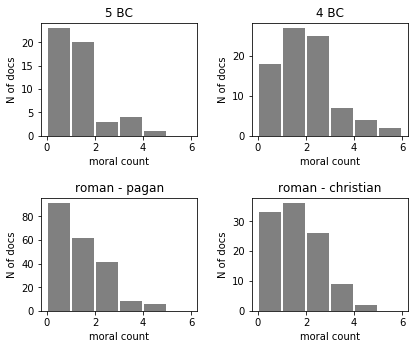

In [0]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(LG_data_results[LG_data_results["century"]==-4.5]["moral_count"], bins=[0,1,2,3,4,5,6], rwidth=0.9, color="gray")
axs[0, 0].set_title('5 BC')
axs[0, 1].hist(LG_data_results[LG_data_results["century"]==-3.5]["moral_count"], bins=[0,1,2,3,4,5,6], rwidth=0.9, color="gray")
axs[0, 1].set_title('4 BC')
axs[1, 0].hist(LG_data_results[(LG_data_results["provenience"]=="pagan") & (LG_data_results["period"]=="roman")]["moral_count"], bins=[0,1,2,3,4,5,6], rwidth=0.9, color="gray")
axs[1, 0].set_title('roman - pagan')
axs[1, 1].hist(LG_data_results[LG_data_results["provenience"]=="christian"]["moral_count"], bins=[0,1,2,3,4,5,6], rwidth=0.9, color="gray")
axs[1, 1].set_title('roman - christian')

for ax in axs.flat:
    ax.set(xlabel='moral count', ylabel='N of docs')

plt.subplots_adjust(top=1, bottom=0, left=0.10, right=0.95, hspace=0.55,
                    wspace=0.35)
fig.savefig(gdrive_root + "figures/hist_moral_counts.png", bbox_inches="tight")

In [0]:
fig.savefig(gdrive_root + "figures/hist_moral_counts.png")

In [0]:
ecdf(LG_data_results[LG_data_results["period"]=="classical"]["moral_count"])[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       5, 6])

In [0]:
sns.scatterplot(x = ecdf(LG_data_results["period"]=="classical"]["moral_count"])[0], y= ecdf(LG_data_results["period"]=="classical"]["moral_count"])[1])

SyntaxError: ignored

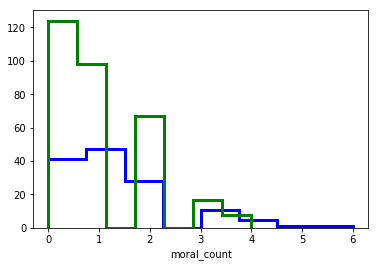

In [0]:
sns.distplot(LG_data_results[LG_data_results["period"]=="classical"]["moral_count"], kde=False, hist_kws={"histtype": "step" , "linewidth": 3, "alpha": 1, "color": "b"})
sns.distplot(LG_data_results[LG_data_results["period"]=="roman"]["moral_count"], kde=False, hist_kws={"histtype": "step" , "linewidth": 3, "alpha": 1, "color": "g"})

In [0]:
 ax = sns.distplot(x, rug=True, rug_kws={"color": "g"}, kde_kws={"color": "k", "lw": 3, "label": "KDE"}, hist_kws={"histtype": "step", "linewidth": 3,    "alpha": 1, "color": "g"})

In [0]:
set_with_dataframe(sh.add_worksheet("results_by_centuries", cols=1, rows=1), LG_data_results.groupby("century")["moral_count"].describe().round(5))

In [0]:
LG_data_results[LG_data_results["provenience"]=="christian"].groupby("century")["moral_count"].describe()

,count,mean,std,min,25%,50%,75%,max
century,,,,,,,,
0.5,29.0,1.000000,0.707107,0.0,1.0,1.0,1.0,3.0
1.5,22.0,1.318182,0.994574,0.0,1.0,1.0,2.0,3.0
2.5,27.0,1.148148,1.321529,0.0,0.0,1.0,2.0,4.0
3.5,28.0,1.214286,1.031258,0.0,0.0,1.0,2.0,3.0


In [0]:
LG_data_results.groupby("period")["moral_count"].describe()

,count,mean,std,min,25%,50%,75%,max
period,,,,,,,,
archaic,6.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
classical,134.0,1.246269,1.197972,0.0,0.0,1.0,2.0,6.0
roman,314.0,1.003185,1.028347,0.0,0.0,1.0,2.0,4.0


In [0]:
import seaborn as sns


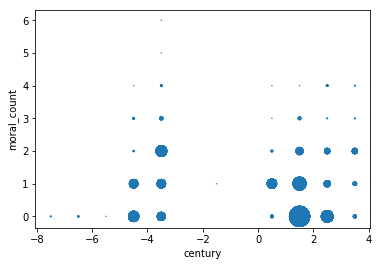

In [0]:
def like_me_here(row):
  like_me_here_count = len(LG_data_results[(LG_data_results["century"]== row["century"]) & (LG_data_results["moral_count"]== row["moral_count"])])
  return like_me_here_count
LG_data_results["like_me_here"] = LG_data_results.apply(lambda row: like_me_here(row), axis=1)

LG_data_results.plot.scatter(x="century", y="moral_count", s=(LG_data_results["like_me_here"]**2)/5)

In [0]:
proxies_df = get_as_dataframe(sh.worksheet("INPUT_proxies"))
proxies_df

,century,kcal,settl,devindex,house,period,SocCx,AfflProg,AfflCons
0,-7.5,21250,87500,1.30,51.0,archaic,1.0,1.0,1.0
1,-6.5,21750,112500,2.50,49.0,archaic,1.0,1.0,1.0
2,-5.5,22500,137500,4.25,70.0,archaic,1.0,1.0,1.0
3,-4.5,23500,150000,6.35,149.0,classical,2.0,3.0,2.0
4,-3.5,25000,150000,8.25,230.0,classical,2.0,3.0,2.0
5,-2.5,26500,225000,7.95,NaN,NaN,NaN,NaN,NaN
6,-1.5,28000,350000,5.85,NaN,NaN,NaN,NaN,NaN
7,-0.5,30000,700000,4.70,NaN,NaN,NaN,NaN,NaN
8,0.5,31000,1000000,NaN,NaN,roman,3.0,2.0,2.0
9,1.5,30500,1000000,NaN,NaN,roman,3.0,2.0,2.0


In [0]:
LG_data_results = LG_data_results.merge(proxies_df, on="century")
LG_data_results.head(3)

,author,work,ids,length_orig,length_lemmata,provenience,century,notes,lemmata,nouns_and_adj,string,nouns_adj_length,theos_egonetwork,moral_terms,moral_count,kcal,settl,devindex,house,period,SocCx,AfflProg,AfflCons
0,Eutropius,Breviarium historiae romanae,stoa0121.stoa001.opp-grc1,26143,13086,pagan,3.5,None,"[ῥωμαϊκός, βασίλεια, προοίμιον, οὐδείς, γίγνομ...","[ῥωμαϊκός, βασίλεια, προοίμιον, οὐδείς, μεῖόν,...",Τῆς Ῥωμαϊκῆς βασιλείας ἐν προοιμίοις οὐδὲν ἐγέ...,8941,"[(προσηγορία, [an appellation, name], 0.25), (...",[],0,28750,800000,NaN,NaN,roman,3.0,2.0,2.0
1,Hegemonius,Acta Archelai,stoa0146d.stoa001.opp-grc1,2725,1161,christian,3.5,None,"[μανιχαῖος, ἀπόστολος, ἰησοῦς, χριστός, πᾶς, ἅ...","[μανιχαῖος, ἀπόστολος, ἰησοῦς, χριστός, πᾶς, ἅ...",Μανιχαῖος ἀπόστολος Ἰησοῦ Χριστοῦ καὶ οἱ σὺν ἐ...,727,"[(εἰρήνη, [peace, peace of mind], 1.0), (πατήρ...","[ἀγαθωσύνη, ἀγαθός, καλός]",3,28750,800000,NaN,NaN,roman,3.0,2.0,2.0
2,Ammonius Grammaticus,De adfinium vocabulorum differentia ΠΕΡΙ ΟΜΟΙΩ...,tlg0708.tlg001.1st1K-grc1,21952,8597,pagan,3.5,None,"[ἀβακιον, διαφέρω, ἄβαξ, πρᾶγμα, παρατίθημι, ἀ...","[ἀβακιον, ἄβαξ, πρᾶγμα, παρατίθημι, ἀβέβηλος, ...","A ἄβαξ καὶ ἀβακιον διαφέρει . ἄβαξ μὲν γάρ , ἐ...",5298,"[(μάχη, [strife, contention, quarrel], 0.5), (...",[ἄξιος],1,28750,800000,NaN,NaN,roman,3.0,2.0,2.0


In [0]:
LG_data_results.groupby("period")["moral_count"].describe()

,count,mean,std,min,25%,50%,75%,max
period,,,,,,,,
archaic,6.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
classical,124.0,1.258065,1.242021,0.0,0.0,1.0,2.0,6.0
roman,219.0,1.027397,1.057597,0.0,0.0,1.0,2.0,4.0


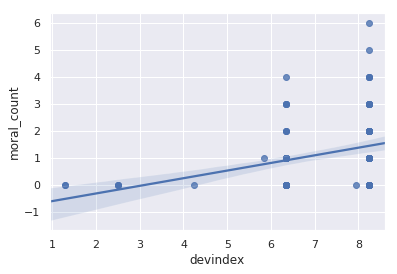

In [0]:
### see https://seaborn.pydata.org/tutorial/regression.html


sns.set(color_codes=True)
sns.regplot(x="devindex", y="moral_count", data=LG_data_results)

In [0]:
LG_data_results["author"] = LG_data_results.apply(lambda row: str(row["author"]), axis=1)

In [0]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [0]:
md = smf.mixedlm("moral_count ~ devindex", LG_data_results[LG_data_results["century"]<0], groups=LG_data_results[LG_data_results["century"]<0]["author"])
mdf = md.fit()
print(mdf.summary())


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: moral_count
No. Observations: 142     Method:             REML       
No. Groups:       27      Scale:              1.0455     
Min. group size:  1       Likelihood:         -214.4877  
Max. group size:  20      Converged:          Yes        
Mean group size:  5.3                                    
----------------------------------------------------------
           Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept  -0.641     0.618  -1.037  0.300  -1.853   0.571
devindex    0.234     0.086   2.718  0.007   0.065   0.403
Group Var   0.213     0.111                               

